<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_Top3ProductosEstrella_desde2021_SegundaSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import pandas as pd
from numpy import abs, array, mean, sqrt, where, nan, sum
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              13                   1           AC            SVE   
1              13                   1           AC            SVE   
2              13                   1           AC            SVE   
3              13                   1           AC            SVE   
4              13                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18112056                  0      2018-11-15   
1   VENTA COMPUTARIZADA          18112055                  0      2018-11-15   
2   VENTA COMPUTARIZADA          18112052                  0      2018-11-15   
3   VENTA COMPUTARIZADA          18112050                  0      2018-11-15   
4   VENTA COMPUTARIZADA          18112049                  0      2018-11-15   

    NombreProducto UnidadMedida  CantidadSalida  PesoSalida  MontoBase  \
0           CUELLO           KG          0.0000      0.6532     2.5760   
1  FILETE A GRANEL           KG          0.0000      1.9826    47.0120   
2  FILETE A GRANEL           KG          0.0000      1.9246    45.6320   
3  FILETE A GRANEL           KG          0.0000      0.8418    19.9640   
4           PIERNA           KG          0.0000      0.1334     2.1160   

   PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0          3.5880         3.5880           0.3698     TROZADO  
1         21.8040        21.8040           6.7546     TROZADO  
2         21.8040        21.8040           6.5559     TROZADO  
3         21.8040        21.8040           2.8686     TROZADO  
4         14.7200        14.7200           0.3036     TROZADO

In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [8]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [9]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (195761, 3)
desde 2021 hasta nov2023   -  (122417, 3)
noviembre 2023             -  (2486, 3)


In [10]:
# df_noviembre.head()
df_todo_hasta_nov

NombreProducto FechaMovimiento  MontoBase
147201                    HIGADO      2021-01-02     3.8270
147206  POLLO SIN MENUDENCIA H-C      2021-01-02    27.8570
147205  POLLO SIN MENUDENCIA H-C      2021-01-02    55.8030
147204  POLLO SIN MENUDENCIA H-C      2021-01-02    30.6160
147203  POLLO SIN MENUDENCIA H-C      2021-01-02   105.4650
...                          ...             ...        ...
195933  POLLO SIN MENUDENCIA H-C      2023-10-31    28.5957
195932            POLLO ESPECIAL      2023-10-31    26.5576
195931  POLLO SIN MENUDENCIA H-C      2023-10-31    30.1621
195930  POLLO SIN MENUDENCIA H-C      2023-10-31    27.5188
195929  POLLO SIN MENUDENCIA H-C      2023-10-31   110.1820

[122417 rows x 3 columns]

## EVALUACION

In [11]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = where(y_true != 0)
        y_true, y_pred = array(y_true)[non_zero_indices], array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, nan)
            return nan

        # Calcular MAPE solo para los valores válidos
        return mean(abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [12]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# Creacion del objeto con los dataframes de los 3 productos


In [13]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase
116355                   PECHUGA      2023-11-01    22.8344
116354           FILETE A GRANEL      2023-11-01    30.1024
116368                    PIERNA      2023-11-01    15.2352
116351                     MUSLO      2023-11-01    21.2152
116352              PIERNA MUSLO      2023-11-01    18.2068
...                          ...             ...        ...
194984            POLLO ESPECIAL      2023-11-30    29.5658
194985            POLLO ESPECIAL      2023-11-30    25.5341
194982            POLLO ESPECIAL      2023-11-30    78.6226
194983  POLLO SIN MENUDENCIA H-C      2023-11-30    29.1386
194981            POLLO ESPECIAL      2023-11-30    29.9663

[2486 rows x 3 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
dtype: object
<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase
147201                    HIGADO      2

### Seleccion de los productos top 3


In [14]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Paso 3: Seleccionar los nombres de los tres primeros productos
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO ESPECIAL', 'POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA',
       'FILETE A GRANEL', 'PIERNA', 'MUSLO', 'ALA PRIMERA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0            POLLO ESPECIAL          998
1  POLLO SIN MENUDENCIA H-C          976
2                    PIERNA          960
3                   PECHUGA          955
4              PIERNA MUSLO          945
5           FILETE A GRANEL          895
6                     MUSLO          883
7                    CUELLO          763
8               ALA PRIMERA          709
9                    HIGADO          687

Días de venta y MontoBase total para cada producto:
             NombreProducto    MontoBase
0            POLLO ESPECIAL 2858247.6380
1  POLLO SIN MENUDENCIA H-C 1731306.6315
2              PIERNA MUSLO  899721.8384
3                   PECHUGA  824782.3092
4

<ipython-input-14-1ff107300cfa>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen 3 DF c/u con los productos mas vendidos

In [15]:
dfs_de_productos = {}

for nombre_producto in top_3_productos['NombreProducto']:

    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    product_df.set_index('FechaMovimiento', inplace=True)

    dfs_de_productos[nombre_producto] = product_df

In [16]:
dfs_de_productos_sumados = {}

for product, product_df in dfs_de_productos.items():

    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    dfs_de_productos_sumados[product] = product_df_sumado

In [17]:
for product, product_df in dfs_de_productos_sumados.items():

    last_date = product_df['FechaMovimiento'].max()

    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:

        new_row = pd.DataFrame([[product, 0, last_day_oct_2023]], columns=['NombreProducto', 'MontoBase', 'FechaMovimiento'])

        product_df = pd.concat([product_df, new_row])

        product_df.sort_values(by=['NombreProducto', 'FechaMovimiento'], inplace=True)

        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    product_df.set_index('FechaMovimiento', inplace=True)
    dfs_de_productos_sumados[product] = product_df

    #product_df.reset_index(inplace=True)

<ipython-input-17-987eb800e297>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-17-987eb800e297>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-17-987eb800e297>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


### Rellenar los dataset con las fechas faltantes
Rellenar las fechas faltantes con el valor del dia anterior

In [18]:
from copy import deepcopy

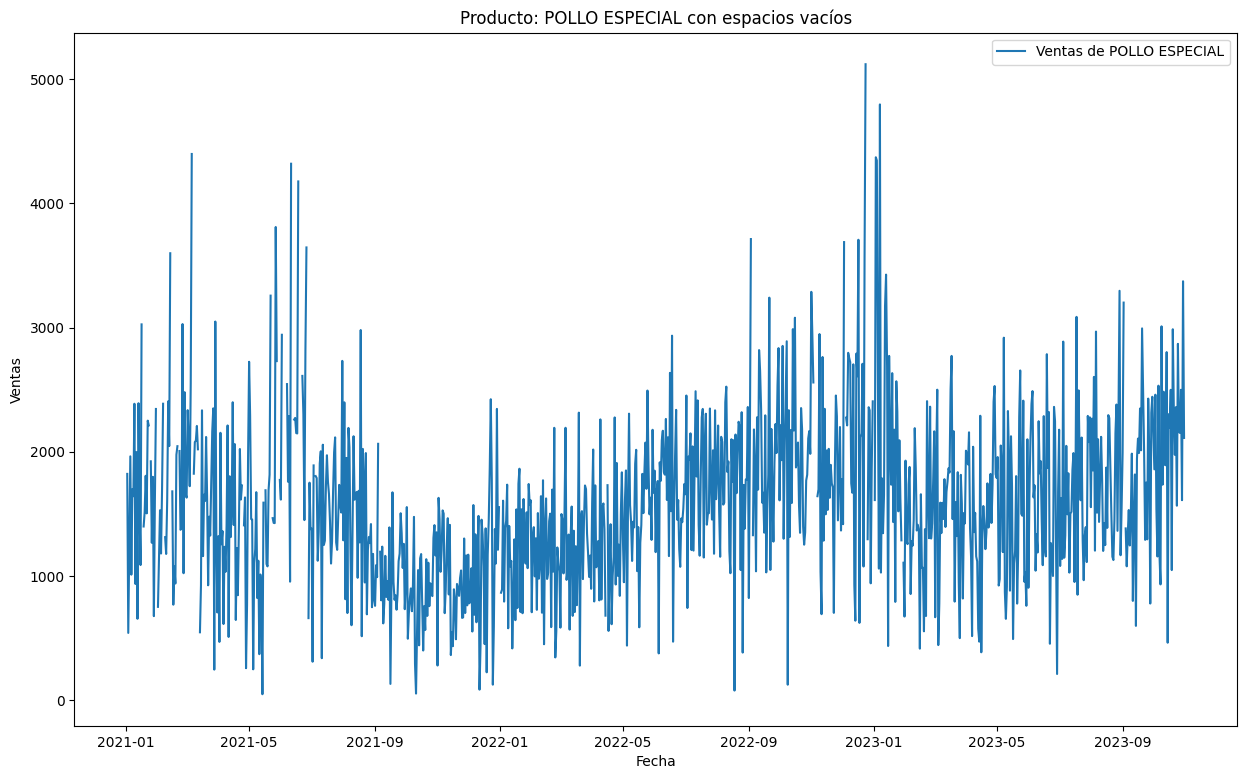

Número de fechas faltantes agregadas en POLLO ESPECIAL:  35
     FechaMovimiento  NombreProducto  MontoBase
0         2021-01-02  POLLO ESPECIAL  1822.6310
1         2021-01-03  POLLO ESPECIAL   543.4340
2         2021-01-04  POLLO ESPECIAL  1221.7920
3         2021-01-05  POLLO ESPECIAL  1963.7850
4         2021-01-06  POLLO ESPECIAL  1012.1080
...              ...             ...        ...
1028      2023-10-27  POLLO ESPECIAL  2152.1624
1029      2023-10-28  POLLO ESPECIAL  2499.2891
1030      2023-10-29  POLLO ESPECIAL  1611.2471
1031      2023-10-30  POLLO ESPECIAL  3372.2990
1032      2023-10-31  POLLO ESPECIAL  2112.0323

[1033 rows x 3 columns]


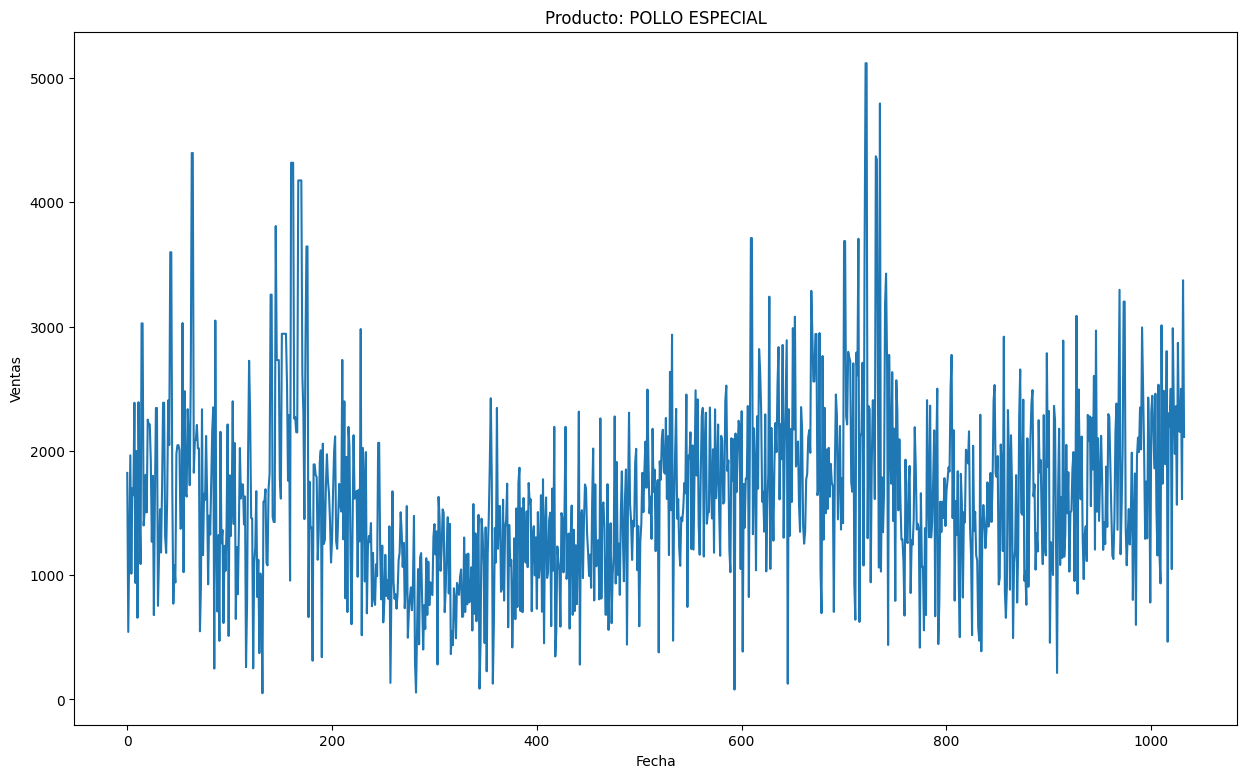

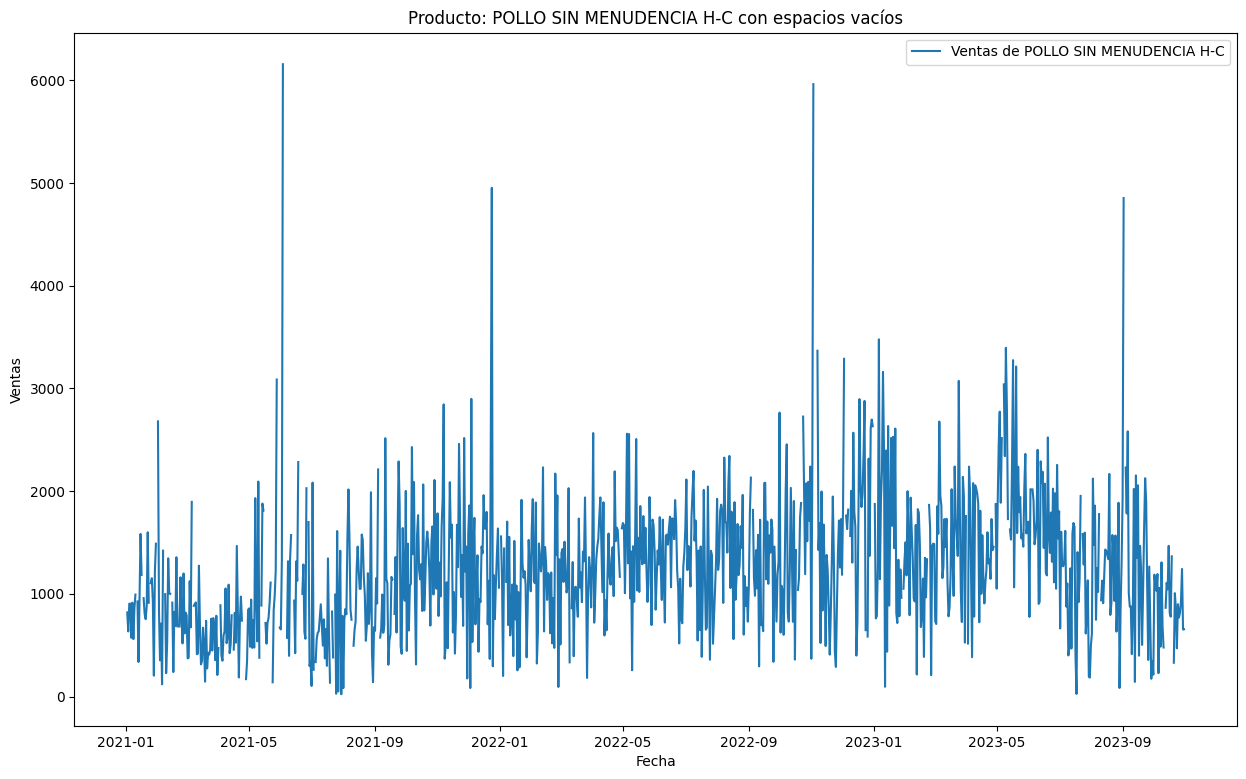

Número de fechas faltantes agregadas en POLLO SIN MENUDENCIA H-C:  57
     FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C   818.4440
1         2021-01-03  POLLO SIN MENUDENCIA H-C   633.5910
2         2021-01-04  POLLO SIN MENUDENCIA H-C   904.3290
3         2021-01-05  POLLO SIN MENUDENCIA H-C   903.1720
4         2021-01-06  POLLO SIN MENUDENCIA H-C   571.2910
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C   816.5305
1029      2023-10-28  POLLO SIN MENUDENCIA H-C   927.1219
1030      2023-10-29  POLLO SIN MENUDENCIA H-C  1241.6123
1031      2023-10-30  POLLO SIN MENUDENCIA H-C   652.0852
1032      2023-10-31  POLLO SIN MENUDENCIA H-C   654.0076

[1033 rows x 3 columns]


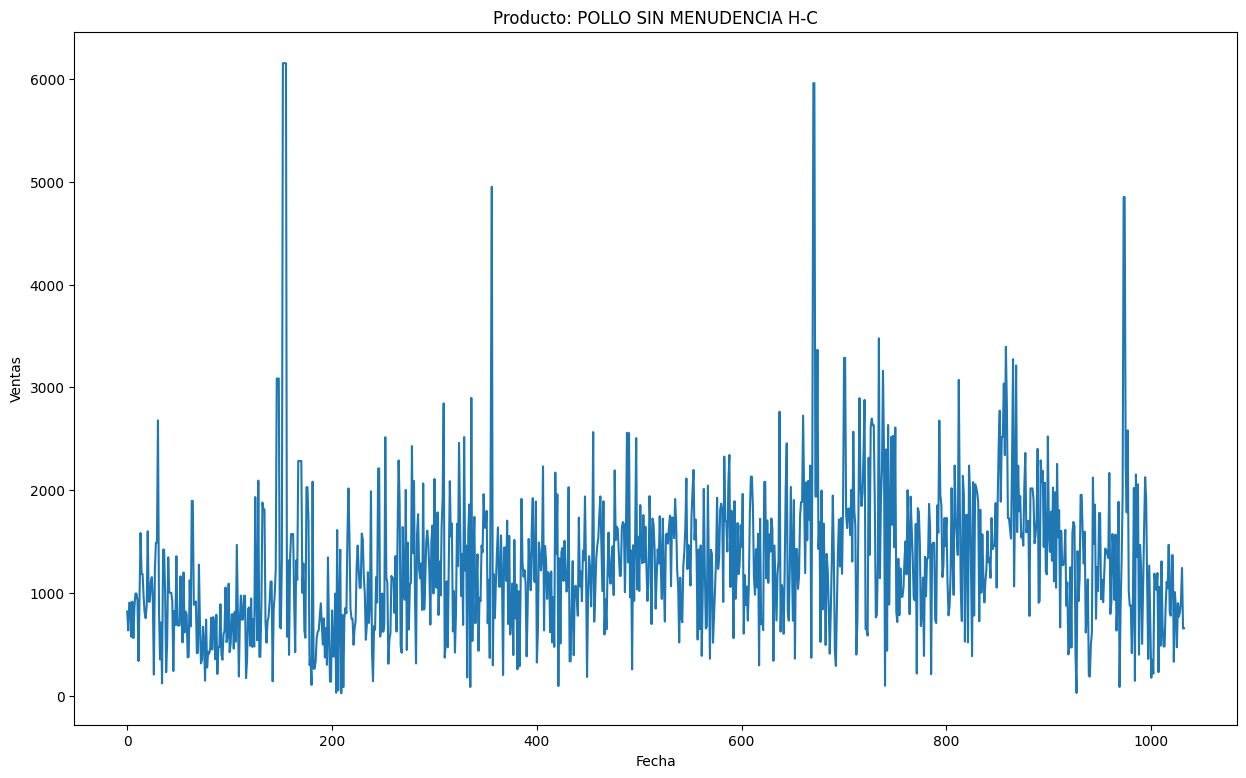

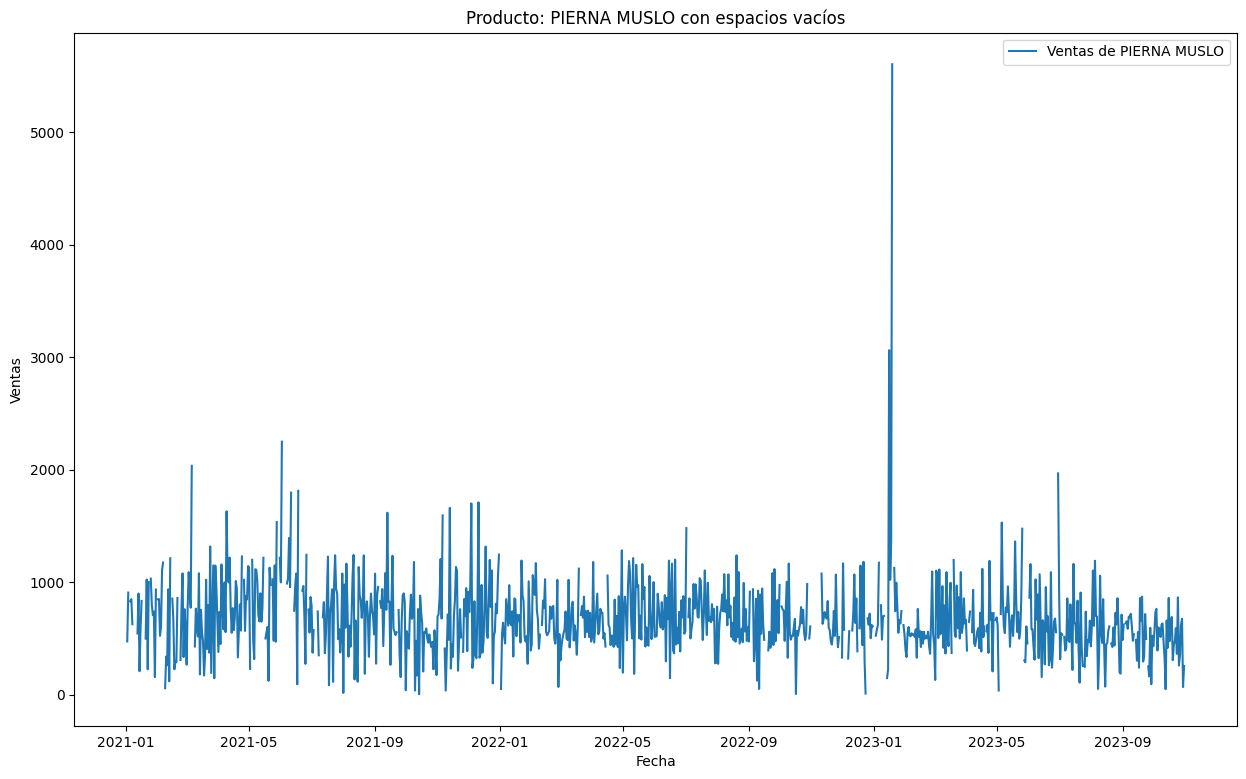

Número de fechas faltantes agregadas en PIERNA MUSLO:  88
     FechaMovimiento NombreProducto  MontoBase
0         2021-01-02   PIERNA MUSLO   473.7080
1         2021-01-03   PIERNA MUSLO   907.9480
2         2021-01-04   PIERNA MUSLO   907.9480
3         2021-01-05   PIERNA MUSLO   831.2200
4         2021-01-06   PIERNA MUSLO   850.4480
...              ...            ...        ...
1028      2023-10-27   PIERNA MUSLO   353.7400
1029      2023-10-28   PIERNA MUSLO   618.4240
1030      2023-10-29   PIERNA MUSLO   675.5468
1031      2023-10-30   PIERNA MUSLO    69.0736
1032      2023-10-31   PIERNA MUSLO   256.0544

[1033 rows x 3 columns]


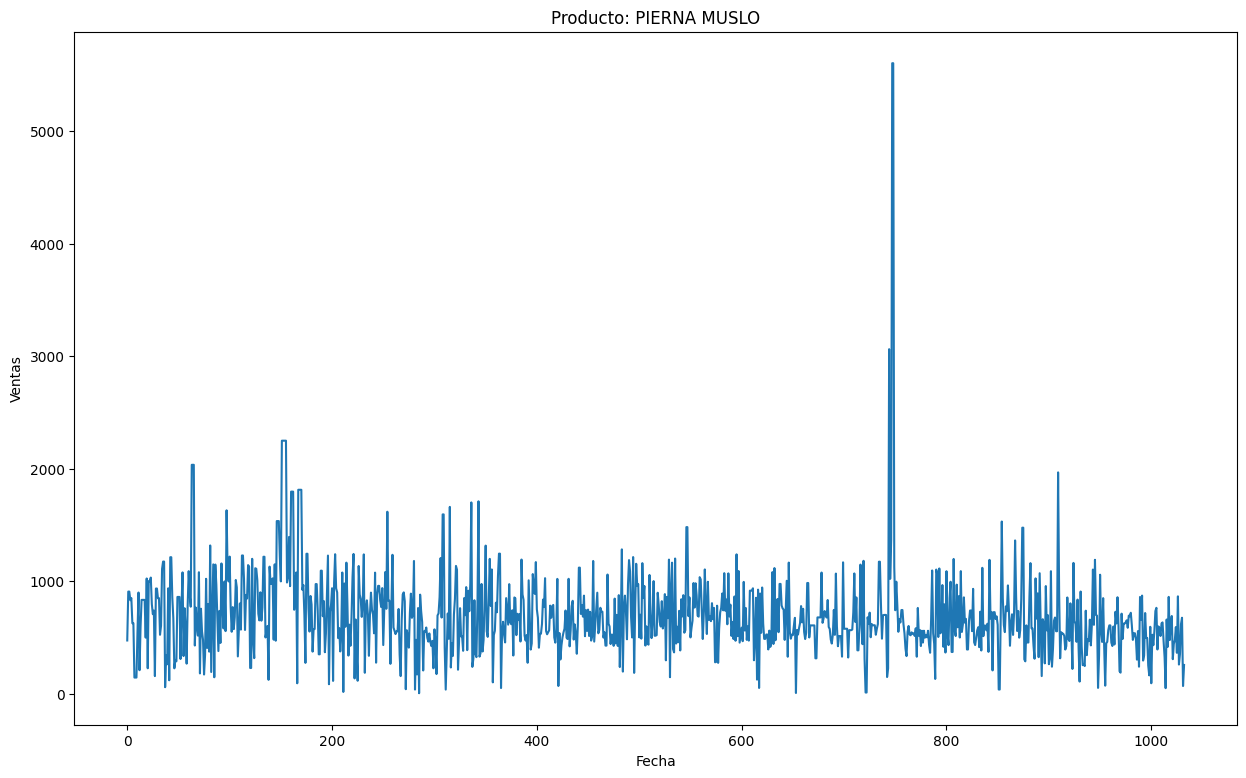

In [19]:
dfs_de_productos_sumados_ffill = deepcopy(dfs_de_productos_sumados)

for product, product_df_sumado_ffill in dfs_de_productos_sumados_ffill.items():

    inicio = product_df_sumado_ffill.index.min()
    fin = product_df_sumado_ffill.index.max()
    fechas_completas = pd.date_range(start=inicio, end=fin)

    fechas_faltantes = fechas_completas.difference(product_df_sumado_ffill.index)
    contador_fechas_faltantes = len(fechas_faltantes)

    product_df_sumado_ffill = product_df_sumado_ffill.reindex(fechas_completas)

    # Graficar con espacios vacíos
    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label = f'Ventas de {product}')
    plt.title(f'Producto: {product} con espacios vacíos')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    product_df_sumado_ffill['MontoBase'].fillna(method='ffill', inplace=True)
    product_df_sumado_ffill['NombreProducto'].fillna(method='ffill', inplace=True)

    print(f"Número de fechas faltantes agregadas en {product}: ", contador_fechas_faltantes)

    product_df_sumado_ffill.reset_index(inplace=True, drop=False)
    product_df_sumado_ffill.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

    print(product_df_sumado_ffill)

    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label=product_df_sumado_ffill['NombreProducto'])
    plt.title(f'Producto: {product}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.show()

    # # Resetear el índice y mantener el nombre de la columna de fecha
    # product_df_sumado_ffill.reset_index(inplace=True)
    # product_df_sumado_ffill.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

    dfs_de_productos_sumados_ffill[product] = product_df_sumado_ffill

In [20]:
print(list(dfs_de_productos_sumados_ffill.values())[1])

     FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C   818.4440
1         2021-01-03  POLLO SIN MENUDENCIA H-C   633.5910
2         2021-01-04  POLLO SIN MENUDENCIA H-C   904.3290
3         2021-01-05  POLLO SIN MENUDENCIA H-C   903.1720
4         2021-01-06  POLLO SIN MENUDENCIA H-C   571.2910
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C   816.5305
1029      2023-10-28  POLLO SIN MENUDENCIA H-C   927.1219
1030      2023-10-29  POLLO SIN MENUDENCIA H-C  1241.6123
1031      2023-10-30  POLLO SIN MENUDENCIA H-C   652.0852
1032      2023-10-31  POLLO SIN MENUDENCIA H-C   654.0076

[1033 rows x 3 columns]


In [21]:
dfs_de_productos_sumados_prophet = deepcopy(dfs_de_productos_sumados_ffill)

for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():

    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

In [22]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C   818.4440
2021-01-03       POLLO SIN MENUDENCIA H-C   633.5910
2021-01-04       POLLO SIN MENUDENCIA H-C   904.3290
2021-01-05       POLLO SIN MENUDENCIA H-C   903.1720
2021-01-06       POLLO SIN MENUDENCIA H-C   571.2910
...                                   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C   816.5305
2023-10-28       POLLO SIN MENUDENCIA H-C   927.1219
2023-10-29       POLLO SIN MENUDENCIA H-C  1241.6123
2023-10-30       POLLO SIN MENUDENCIA H-C   652.0852
2023-10-31       POLLO SIN MENUDENCIA H-C   654.0076

[976 rows x 2 columns]>
ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of              ds            NombreProducto      

In [23]:
# for product, product_df in dfs_de_productos_sumados_prophet.items():
#     # Crear un modelo de Prophet
#     modelo = Prophet()
#     print(product_df)

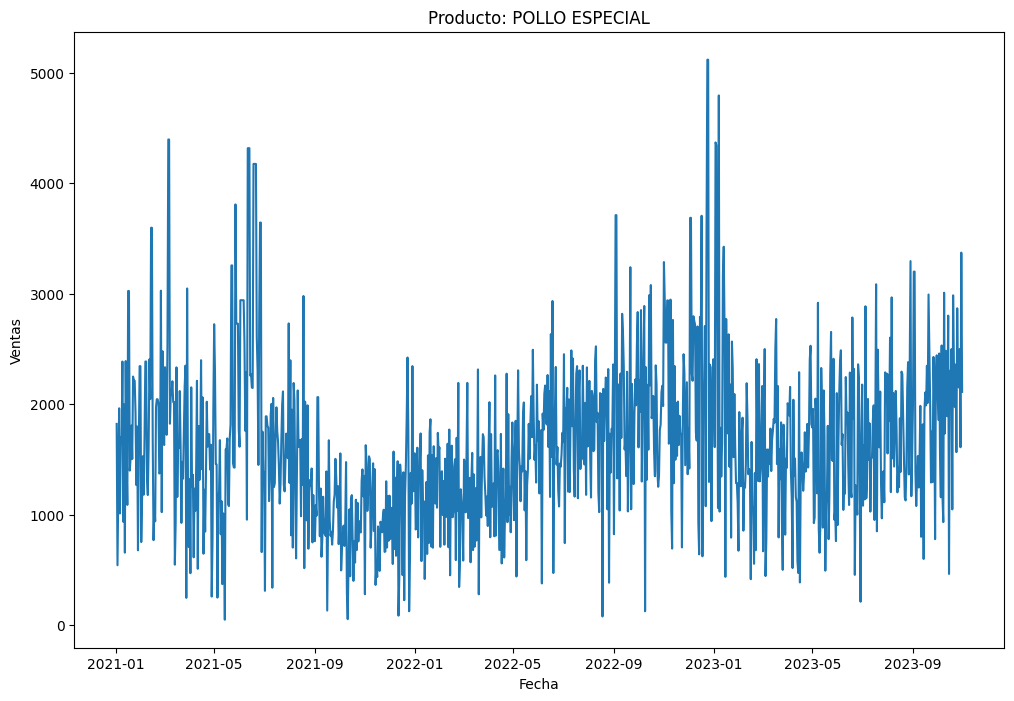

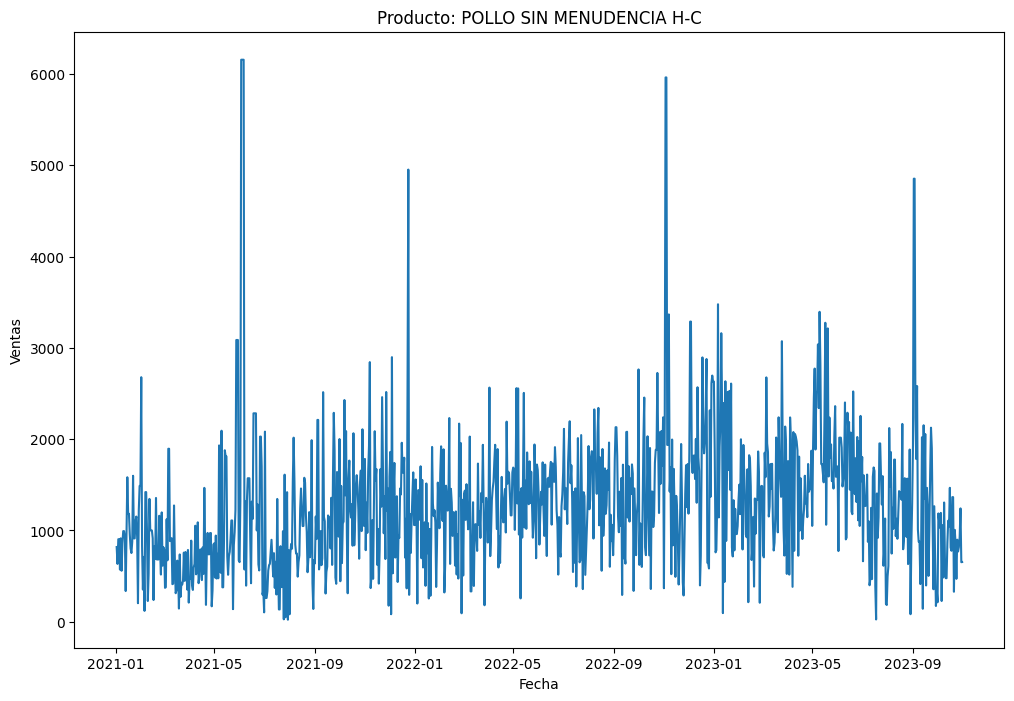

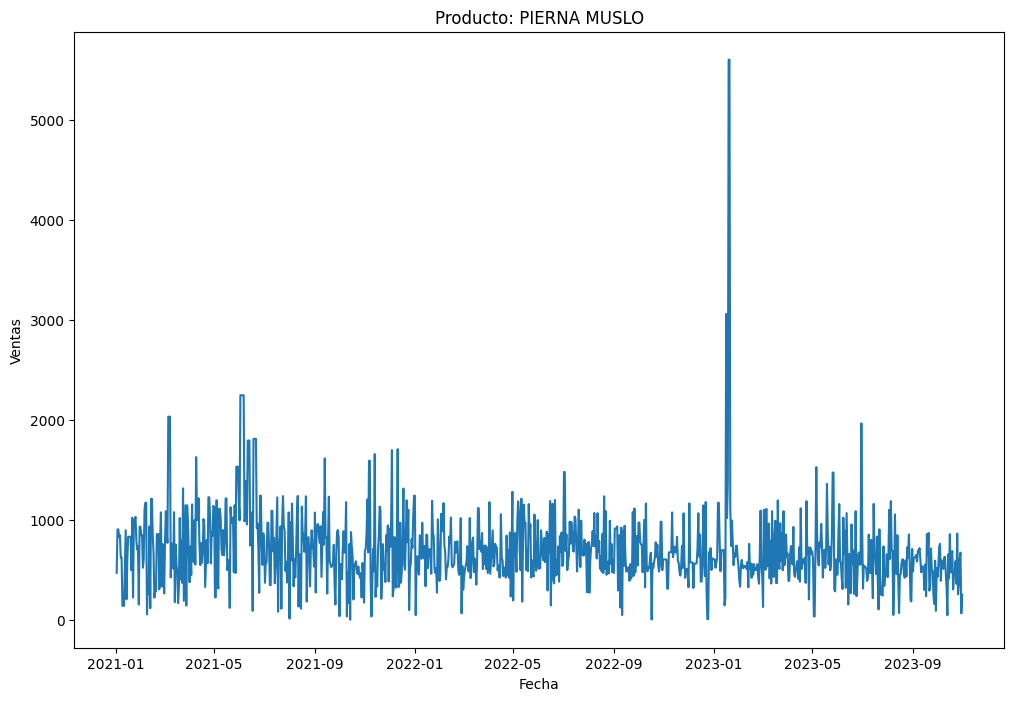

In [24]:
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas')
    plt.show()

In [25]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [26]:
dfs_de_productos_sumados

{'POLLO ESPECIAL':                  NombreProducto  MontoBase
 FechaMovimiento                           
 2021-01-02       POLLO ESPECIAL  1822.6310
 2021-01-03       POLLO ESPECIAL   543.4340
 2021-01-04       POLLO ESPECIAL  1221.7920
 2021-01-05       POLLO ESPECIAL  1963.7850
 2021-01-06       POLLO ESPECIAL  1012.1080
 ...                         ...        ...
 2023-10-27       POLLO ESPECIAL  2152.1624
 2023-10-28       POLLO ESPECIAL  2499.2891
 2023-10-29       POLLO ESPECIAL  1611.2471
 2023-10-30       POLLO ESPECIAL  3372.2990
 2023-10-31       POLLO ESPECIAL  2112.0323
 
 [998 rows x 2 columns],
 'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase
 FechaMovimiento                                     
 2021-01-02       POLLO SIN MENUDENCIA H-C   818.4440
 2021-01-03       POLLO SIN MENUDENCIA H-C   633.5910
 2021-01-04       POLLO SIN MENUDENCIA H-C   904.3290
 2021-01-05       POLLO SIN MENUDENCIA H-C   903.1720
 2021-01-06       POLLO SIN MEN

In [27]:
dfs_de_productos_sumados_lstm = deepcopy(dfs_de_productos_sumados_ffill)

for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # print(product_df_lstm.head)
    # print(product_df_lstm.dtypes)

    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    product_df_lstm.sort_index(inplace=True)

    dfs_de_productos_sumados_lstm[product] = product_df_lstm

NombreProducto     object
MontoBase         float64
dtype: object
NombreProducto     object
MontoBase         float64
dtype: object
NombreProducto     object
MontoBase         float64
dtype: object


In [28]:
dfs_de_productos_sumados_arima = deepcopy(dfs_de_productos_sumados_ffill)

for product, product_df_arima in dfs_de_productos_sumados_arima.items():

    product_df_arima['FechaMovimiento'] = product_df_arima['FechaMovimiento'].dt.date

    product_df_arima.set_index('FechaMovimiento', inplace=True)

    product_df_arima.sort_index(inplace=True)

In [29]:
print(list(dfs_de_productos_sumados_arima.values())[2])

                NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02        PIERNA MUSLO   473.7080
2021-01-03        PIERNA MUSLO   907.9480
2021-01-04        PIERNA MUSLO   907.9480
2021-01-05        PIERNA MUSLO   831.2200
2021-01-06        PIERNA MUSLO   850.4480
...                        ...        ...
2023-10-27        PIERNA MUSLO   353.7400
2023-10-28        PIERNA MUSLO   618.4240
2023-10-29        PIERNA MUSLO   675.5468
2023-10-30        PIERNA MUSLO    69.0736
2023-10-31        PIERNA MUSLO   256.0544

[1033 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [30]:
dfs_de_Noviembre = {}

for product in top_3_productos['NombreProducto']:

    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)

    dfs_de_Noviembre[product] = product_nov

In [31]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350
2023-11-16       POLLO SIN MENUDENCIA H-C   943.6492
2023-11-17       POLLO SIN MENUDENCIA H-C   683.4933
2023-11-18       POLLO SIN MENUDENCIA H-C   77

In [32]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-17'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex(['2023-11-10'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO SIN MENUDENCIA H-C en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PIERNA MUSLO son: DatetimeIndex(['2023-11-23', '2023-11-24', '2023-11-25', '2023-11-27',
               '2023-11-28', '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PIERNA MUSLO en las fechas faltantes.
Se agregaron 7 registros de venta 0 para el producto

In [33]:
# print(dfs_noviembre_sumados)

### Visualizar top 3 ventas reales Noviembre


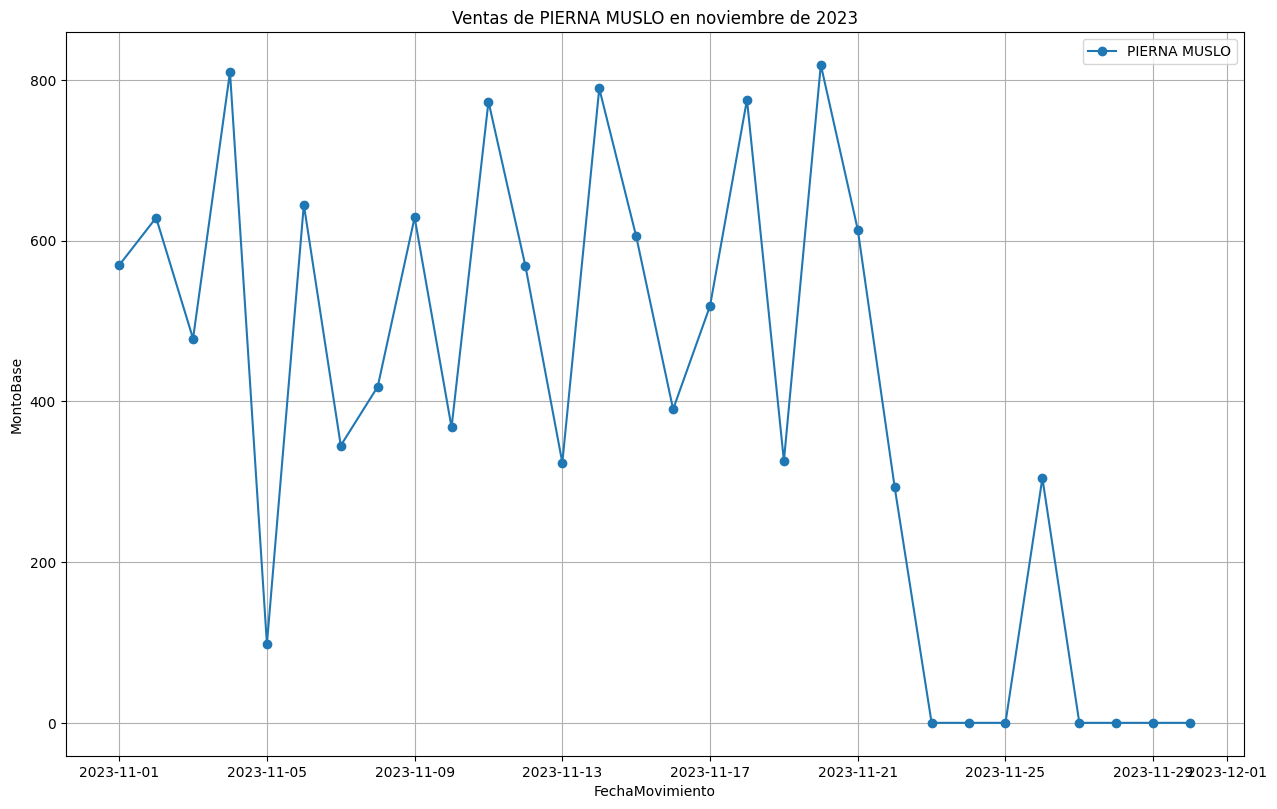

In [34]:
# Graficar el DataFrame
plt.figure(figsize=(15.2, 9.4))
plt.plot(list(dfs_noviembre_sumados.values())[2].index, list(dfs_noviembre_sumados.values())[2]['MontoBase'], label='PIERNA MUSLO', marker='o')
plt.title('Ventas de PIERNA MUSLO en noviembre de 2023')
plt.xlabel('FechaMovimiento')
plt.ylabel('MontoBase')
plt.legend()
plt.grid(True)
plt.show()

# PROPHET


## Predecir cada uno de los 3 principales productos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/6pf9iynd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/jwl7rrsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21535', 'data', 'file=/tmp/tmpjn2ycbfs/6pf9iynd.json', 'init=/tmp/tmpjn2ycbfs/jwl7rrsb.json', 'output', 'file=/tmp/tmpjn2ycbfs/prophet_modeljkjgt_90/prophet_model-20240320155814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


             ds  NombreProducto         y
0    2021-01-02  POLLO ESPECIAL 1822.6310
1    2021-01-03  POLLO ESPECIAL  543.4340
2    2021-01-04  POLLO ESPECIAL 1221.7920
3    2021-01-05  POLLO ESPECIAL 1963.7850
4    2021-01-06  POLLO ESPECIAL 1012.1080
...         ...             ...       ...
1028 2023-10-27  POLLO ESPECIAL 2152.1624
1029 2023-10-28  POLLO ESPECIAL 2499.2891
1030 2023-10-29  POLLO ESPECIAL 1611.2471
1031 2023-10-30  POLLO ESPECIAL 3372.2990
1032 2023-10-31  POLLO ESPECIAL 2112.0323

[1033 rows x 3 columns]


15:58:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


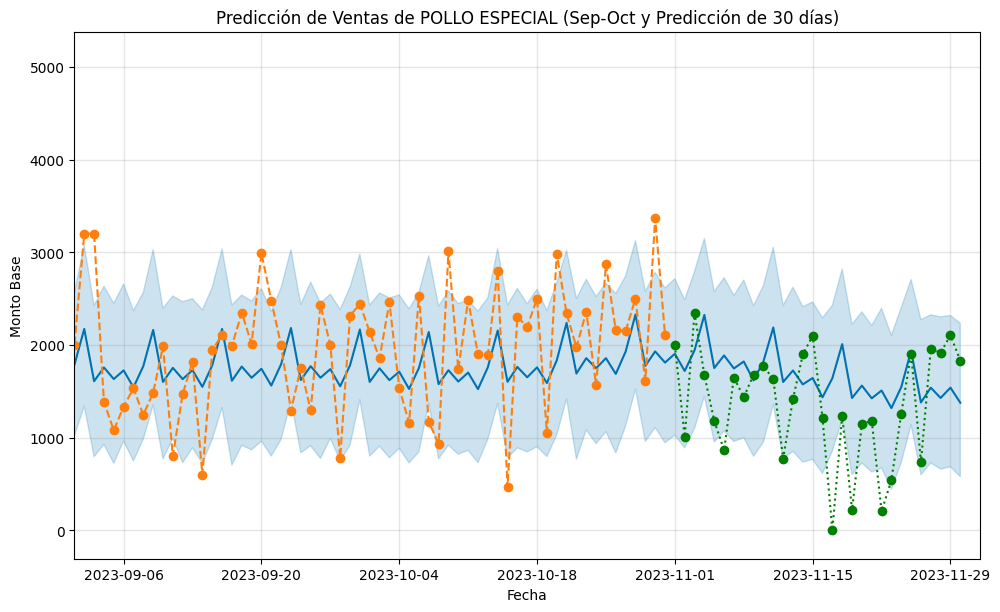

Predicción con todos los valores para POLLO ESPECIAL:
             ds      yhat
1033 2023-11-01 1904.6724
1034 2023-11-02 1719.1750
1035 2023-11-03 1942.6333
1036 2023-11-04 2324.3057
1037 2023-11-05 1750.9780
1038 2023-11-06 1887.0078
1039 2023-11-07 1746.5221
1040 2023-11-08 1821.5955
1041 2023-11-09 1617.1638
1042 2023-11-10 1822.8342
1043 2023-11-11 2188.2710
1044 2023-11-12 1600.6430
1045 2023-11-13 1724.6591
1046 2023-11-14 1574.7572
1047 2023-11-15 1643.2747
1048 2023-11-16 1435.3553
1049 2023-11-17 1640.7539
1050 2023-11-18 2009.2179
1051 2023-11-19 1427.9320
1052 2023-11-20 1561.5527
1053 2023-11-21 1424.3977
1054 2023-11-22 1508.6180
1055 2023-11-23 1319.1089
1056 2023-11-24 1545.3193
1057 2023-11-25 1936.6396
1058 2023-11-26 1379.8538
1059 2023-11-27 1539.1830
1060 2023-11-28 1428.4834
1061 2023-11-29 1539.4291
1062 2023-11-30 1376.4326


<Figure size 1600x1000 with 0 Axes>

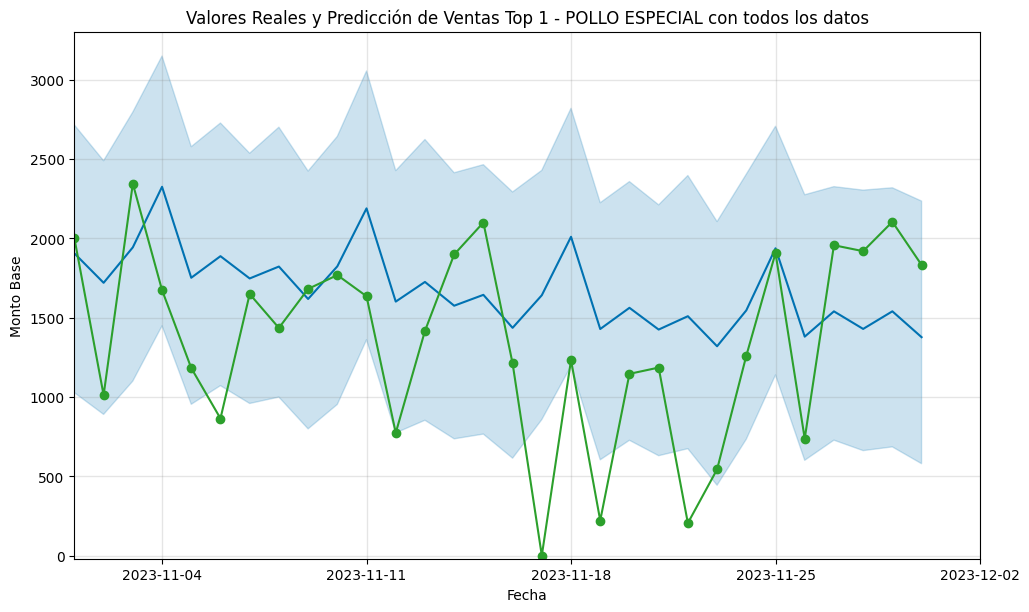

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/qtev9wo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/fov37xo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5359', 'data', 'file=/tmp/tmpjn2ycbfs/qtev9wo4.json', 'init=/tmp/tmpjn2ycbfs/fov37xo8.json', 'output', 'file=/tmp/tmpjn2ycbfs/prophet_model5spneoh5/prophet_model-20240320155815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing


             ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C  818.4440
1    2021-01-03  POLLO SIN MENUDENCIA H-C  633.5910
2    2021-01-04  POLLO SIN MENUDENCIA H-C  904.3290
3    2021-01-05  POLLO SIN MENUDENCIA H-C  903.1720
4    2021-01-06  POLLO SIN MENUDENCIA H-C  571.2910
...         ...                       ...       ...
1028 2023-10-27  POLLO SIN MENUDENCIA H-C  816.5305
1029 2023-10-28  POLLO SIN MENUDENCIA H-C  927.1219
1030 2023-10-29  POLLO SIN MENUDENCIA H-C 1241.6123
1031 2023-10-30  POLLO SIN MENUDENCIA H-C  652.0852
1032 2023-10-31  POLLO SIN MENUDENCIA H-C  654.0076

[1033 rows x 3 columns]


INFO:cmdstanpy:Chain [1] done processing


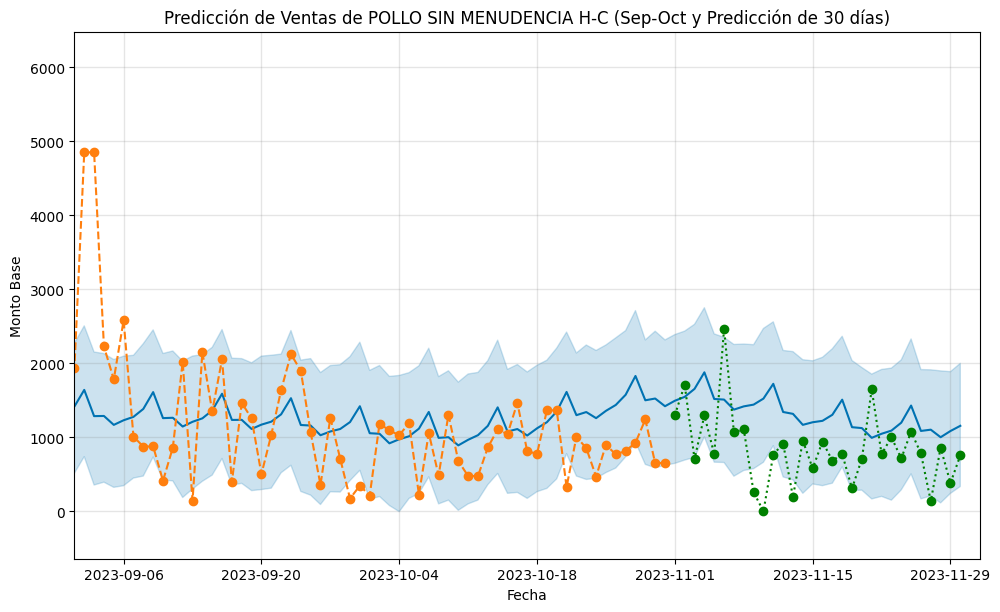

Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1033 2023-11-01 1494.7080
1034 2023-11-02 1547.1585
1035 2023-11-03 1655.1986
1036 2023-11-04 1878.8657
1037 2023-11-05 1518.6102
1038 2023-11-06 1510.3559
1039 2023-11-07 1374.9183
1040 2023-11-08 1418.5732
1041 2023-11-09 1442.2222
1042 2023-11-10 1523.6755
1043 2023-11-11 1723.5082
1044 2023-11-12 1342.6520
1045 2023-11-13 1317.4443
1046 2023-11-14 1169.0368
1047 2023-11-15 1203.9566
1048 2023-11-16 1223.2661
1049 2023-11-17 1304.8419
1050 2023-11-18 1509.2302
1051 2023-11-19 1137.2388
1052 2023-11-20 1124.9895
1053 2023-11-21  993.3322
1054 2023-11-22 1048.4124
1055 2023-11-23 1090.8412
1056 2023-11-24 1197.9837
1057 2023-11-25 1429.8271
1058 2023-11-26 1086.5853
1059 2023-11-27 1103.7652
1060 2023-11-28 1001.5946
1061 2023-11-29 1085.6040
1062 2023-11-30 1155.8100


<Figure size 1600x1000 with 0 Axes>

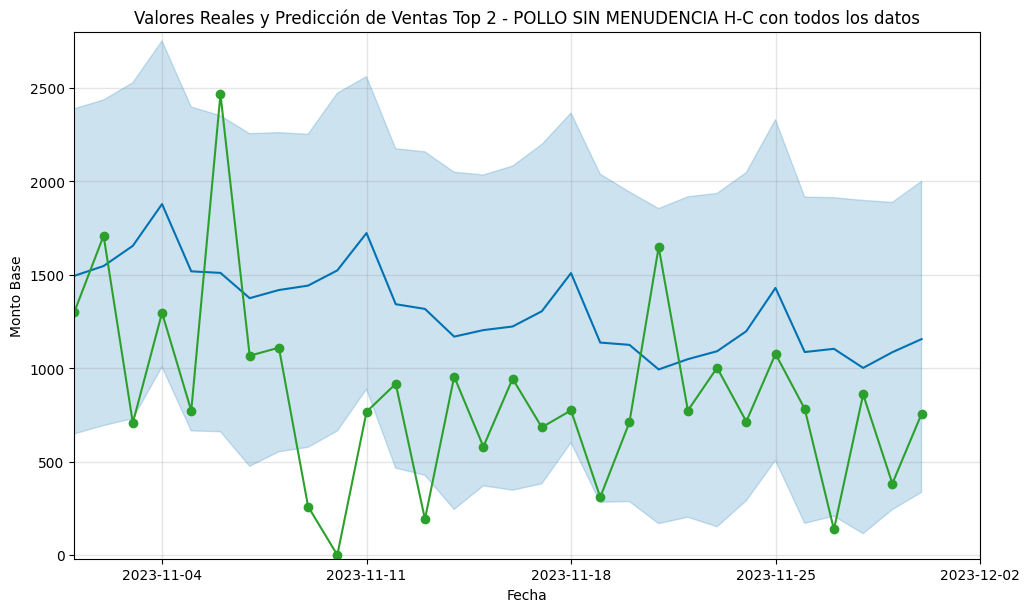

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/ad4q520k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjn2ycbfs/yn5be5xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64173', 'data', 'file=/tmp/tmpjn2ycbfs/ad4q520k.json', 'init=/tmp/tmpjn2ycbfs/yn5be5xq.json', 'output', 'file=/tmp/tmpjn2ycbfs/prophet_modelabzuk676/prophet_model-20240320155817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 473.7080
1    2021-01-03   PIERNA MUSLO 907.9480
2    2021-01-04   PIERNA MUSLO 907.9480
3    2021-01-05   PIERNA MUSLO 831.2200
4    2021-01-06   PIERNA MUSLO 850.4480
...         ...            ...      ...
1028 2023-10-27   PIERNA MUSLO 353.7400
1029 2023-10-28   PIERNA MUSLO 618.4240
1030 2023-10-29   PIERNA MUSLO 675.5468
1031 2023-10-30   PIERNA MUSLO  69.0736
1032 2023-10-31   PIERNA MUSLO 256.0544

[1033 rows x 3 columns]


15:58:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


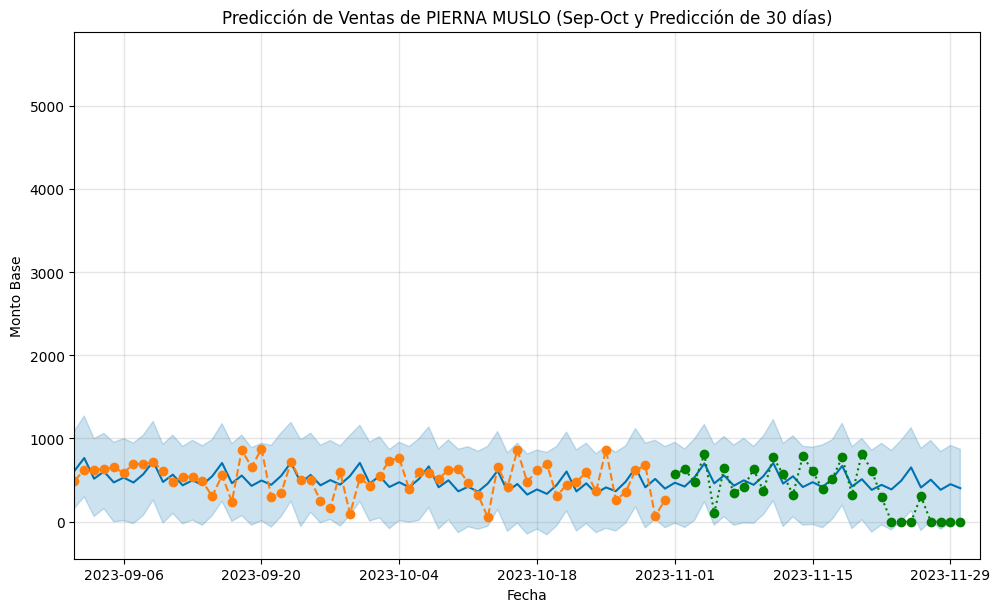

Predicción con todos los valores para PIERNA MUSLO:
             ds     yhat
1033 2023-11-01 468.0379
1034 2023-11-02 421.8924
1035 2023-11-03 534.0454
1036 2023-11-04 699.1809
1037 2023-11-05 460.1239
1038 2023-11-06 555.1926
1039 2023-11-07 432.2749
1040 2023-11-08 496.5578
1041 2023-11-09 442.9463
1042 2023-11-10 547.3315
1043 2023-11-11 704.6242
1044 2023-11-12 457.8779
1045 2023-11-13 545.6339
1046 2023-11-14 415.9916
1047 2023-11-15 474.3308
1048 2023-11-16 415.7257
1049 2023-11-17 516.2072
1050 2023-11-18 670.7928
1051 2023-11-19 422.6057
1052 2023-11-20 510.2179
1053 2023-11-21 381.7193
1054 2023-11-22 442.4401
1055 2023-11-23 387.3662
1056 2023-11-24 492.4035
1057 2023-11-25 652.4119
1058 2023-11-26 410.3284
1059 2023-11-27 504.5164
1060 2023-11-28 382.8399
1061 2023-11-29 450.3941
1062 2023-11-30 401.9266


<Figure size 1600x1000 with 0 Axes>

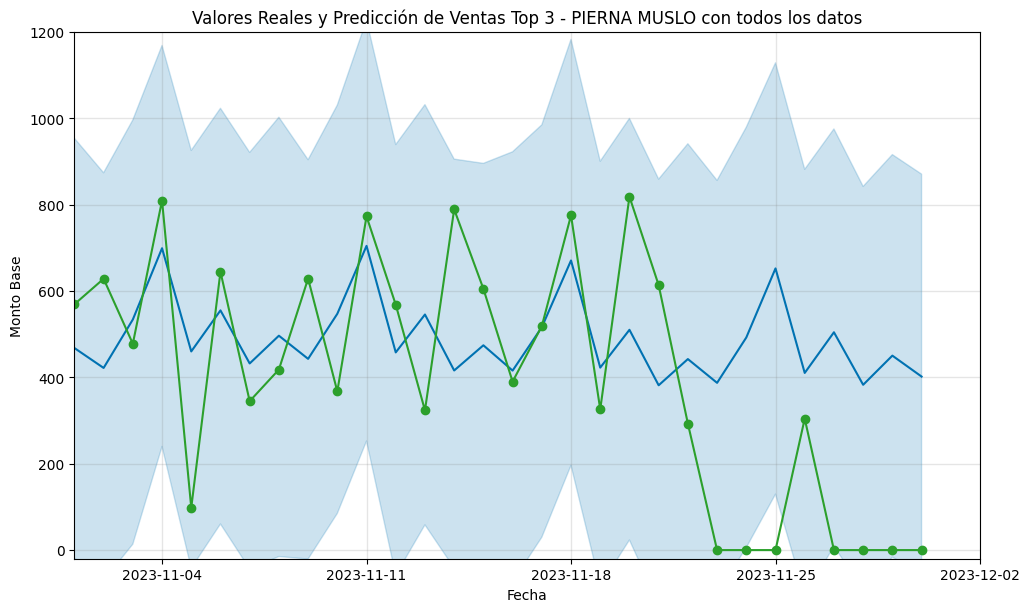

In [35]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

contador = 0

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    contador += 1
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='tab:orange', marker='o', linestyle='dashed')
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label=f'Ventas reales noviembre - {product}', color='green', marker='o', linestyle='dotted')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    #Para el parametro del eje Y en el grafico del mes de noviembre
    if contador == 1:
        Minimo_Y = -20
        Maximo_Y = 3300
    elif contador == 2:
        Minimo_Y = -20
        Maximo_Y = 2800
    elif contador == 3:
        Minimo_Y = -20
        Maximo_Y = 1200

    #Graficar solo Noviembre
    plt.figure(figsize=(16, 10))
    fig = modelo.plot(prediccion)
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label='Ventas reales de noviembre', color='tab:green', marker='o')
    plt.title(f'Valores Reales y Predicción de Ventas Top {contador} - {product} con todos los datos')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.xlim([fecha_inicio_nov, fecha_fin])
    plt.ylim([Minimo_Y, Maximo_Y])
    plt.show()

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

In [36]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head())

    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                 NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL
FechaMovimiento                                                       
2023-11-01       POLLO ESPECIAL  1999.7321                   1904.6724
2023-11-02       POLLO ESPECIAL  1011.2892                   1719.1750
2023-11-03       POLLO ESPECIAL  2343.7883                   1942.6333
2023-11-04       POLLO ESPECIAL  1673.2089                   2324.3057
2023-11-05       POLLO ESPECIAL  1181.9289                   1750.9780
Evaluation metric results:  
MSE is : 426792.14882945165
MAE is : 533.0151344468478
R2 is : -0.1750863323293388 %
------------------------------
MRSE is : 653.2933099530804
MAPE is : 76.34780305799396 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENU

# LSTM


In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [38]:
print(list(dfs_de_productos_sumados_lstm.values())[0])
print(list(dfs_de_productos_sumados_lstm.values())[0].dtypes)

                 NombreProducto  MontoBase
FechaMovimiento                           
2021-01-02       POLLO ESPECIAL  1822.6310
2021-01-03       POLLO ESPECIAL   543.4340
2021-01-04       POLLO ESPECIAL  1221.7920
2021-01-05       POLLO ESPECIAL  1963.7850
2021-01-06       POLLO ESPECIAL  1012.1080
...                         ...        ...
2023-10-27       POLLO ESPECIAL  2152.1624
2023-10-28       POLLO ESPECIAL  2499.2891
2023-10-29       POLLO ESPECIAL  1611.2471
2023-10-30       POLLO ESPECIAL  3372.2990
2023-10-31       POLLO ESPECIAL  2112.0323

[1033 rows x 2 columns]
NombreProducto     object
MontoBase         float64
dtype: object


In [39]:
# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Longitud del producto - POLLO ESPECIAL : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                           

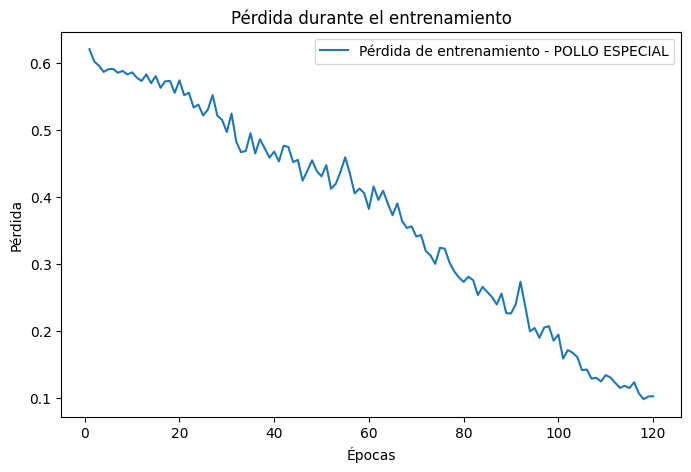

1/1 [==============================] - 1s 851ms/step
31


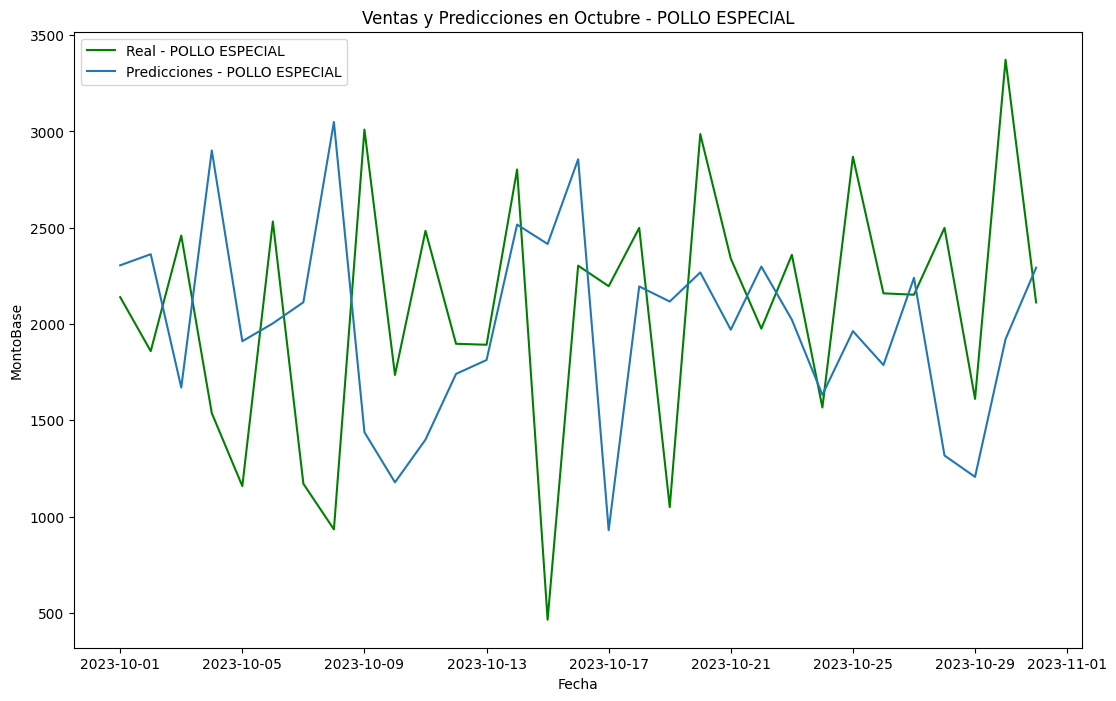

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 56ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_POLLO ESPECIAL
FechaMovimiento                         
2023-11-01                     2362.4719
2023-11-02                     1670.1228
2023-11-03                     2901.1082
2023-11-04                     1910.6652
2023-11-05                     2003.3877
2023-11-06                     2113.0151
2023-11-07                     3049.0173
2023-11-08                     1438.2524
2023-11-09                     1178.0149
2023-11-10                     1399.8282
2023-11-11                     1740.9181
2023-11-12                     1813.3029
2023-11-13                     2516.3577
2023-11-14                     2415.5630
2023-11-15                     2855.3689
2023-11-16                      929.8908
2023-11-17                     2195.2114


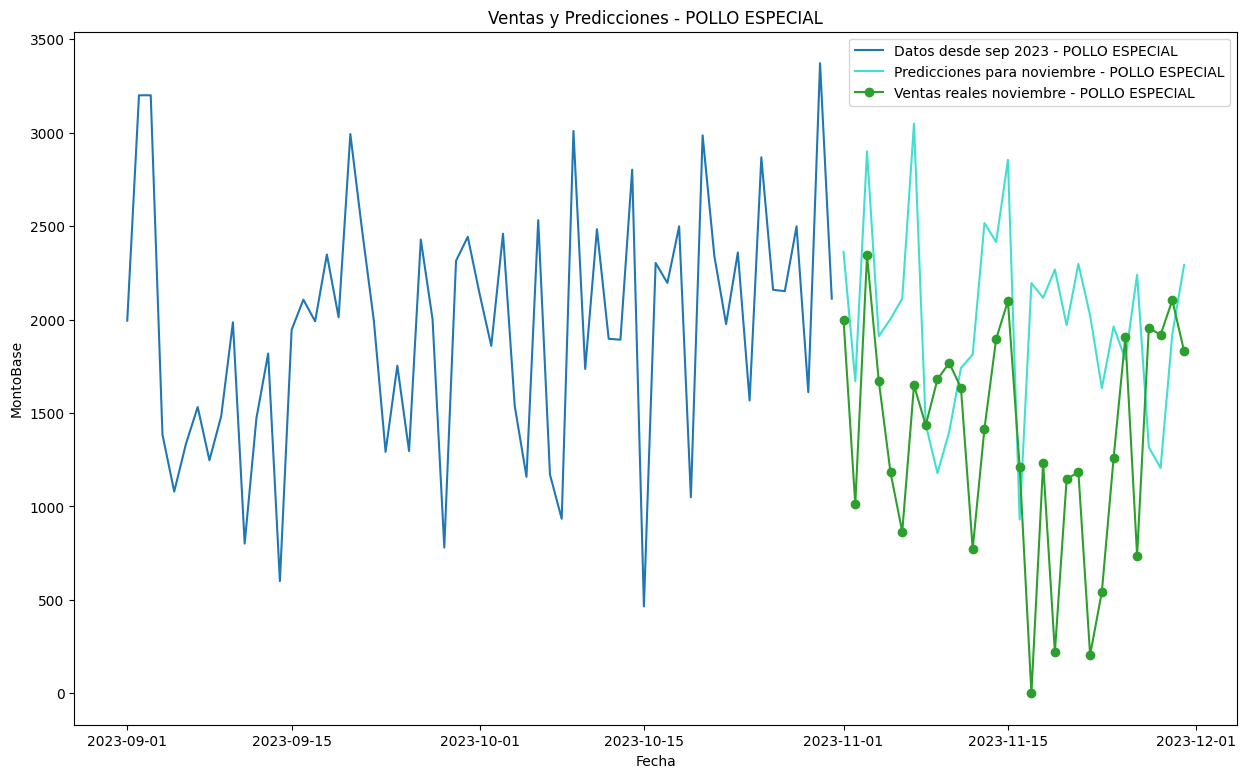

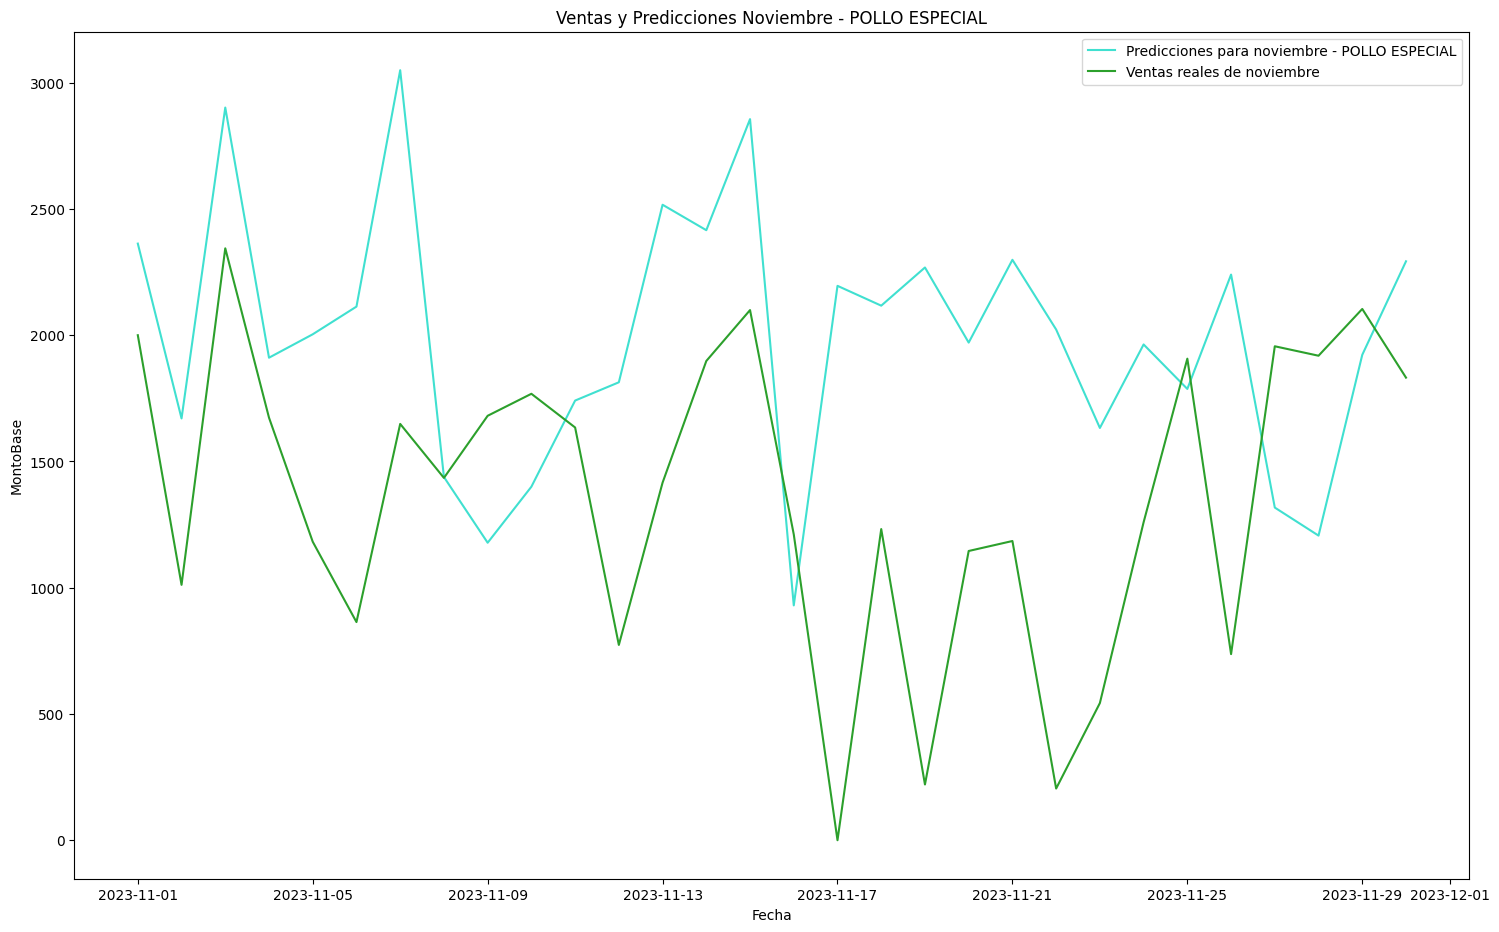

Longitud del producto - POLLO SIN MENUDENCIA H-C : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_2 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
               

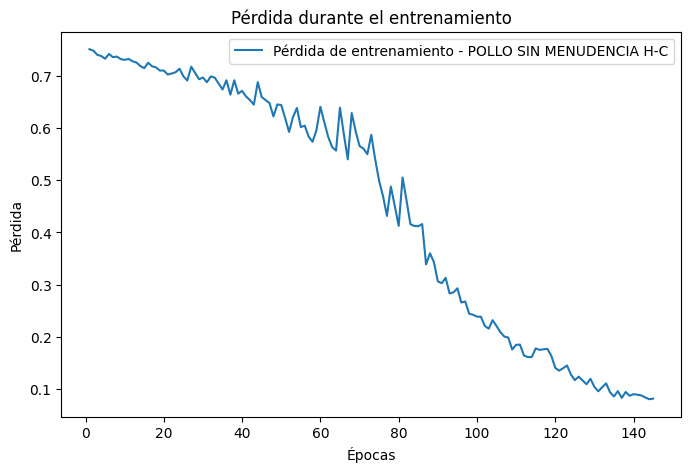

1/1 [==============================] - 1s 793ms/step
31


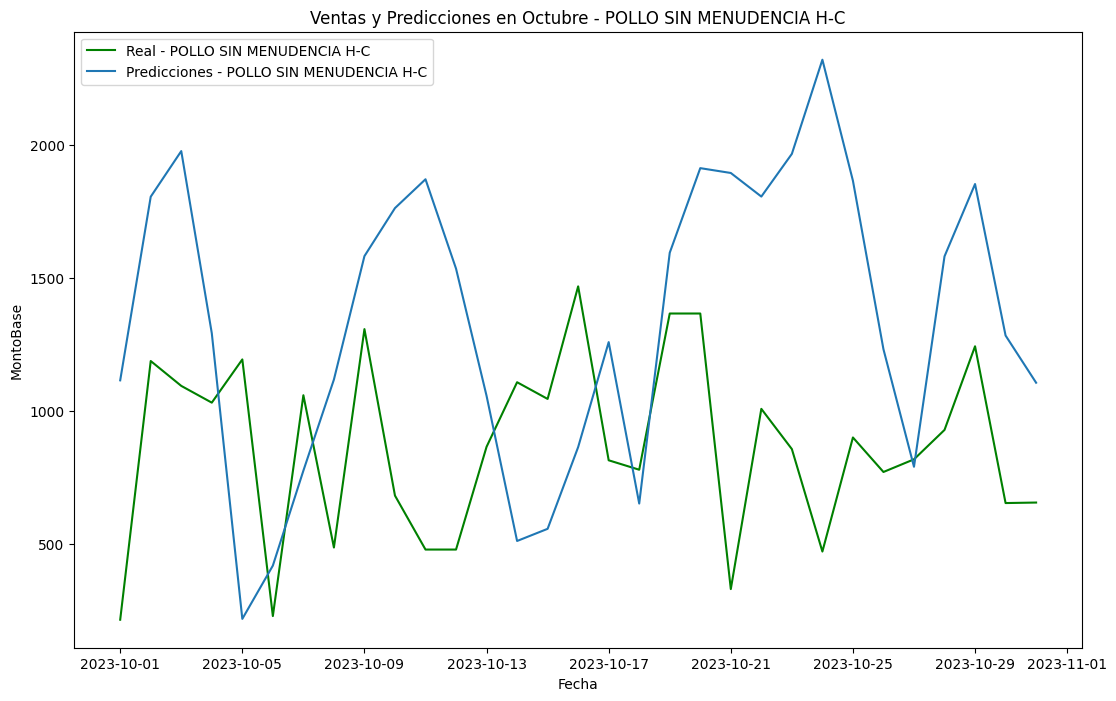

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 57ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                               1804.0848
2023-11-02                               1975.6282
2023-11-03                               1290.7650
2023-11-04                                216.5479
2023-11-05                                416.7683
2023-11-06                                773.8953
2023-11-07                               1116.4696
2023-11-08                               1580.6512
2023-11-09                               1761.2988
2023-11-10                               1869.6626
2023-11-11                               1533.6295
2023-11-12                               1055.2242
2023-11-13                                509.4790
2023-11-14    

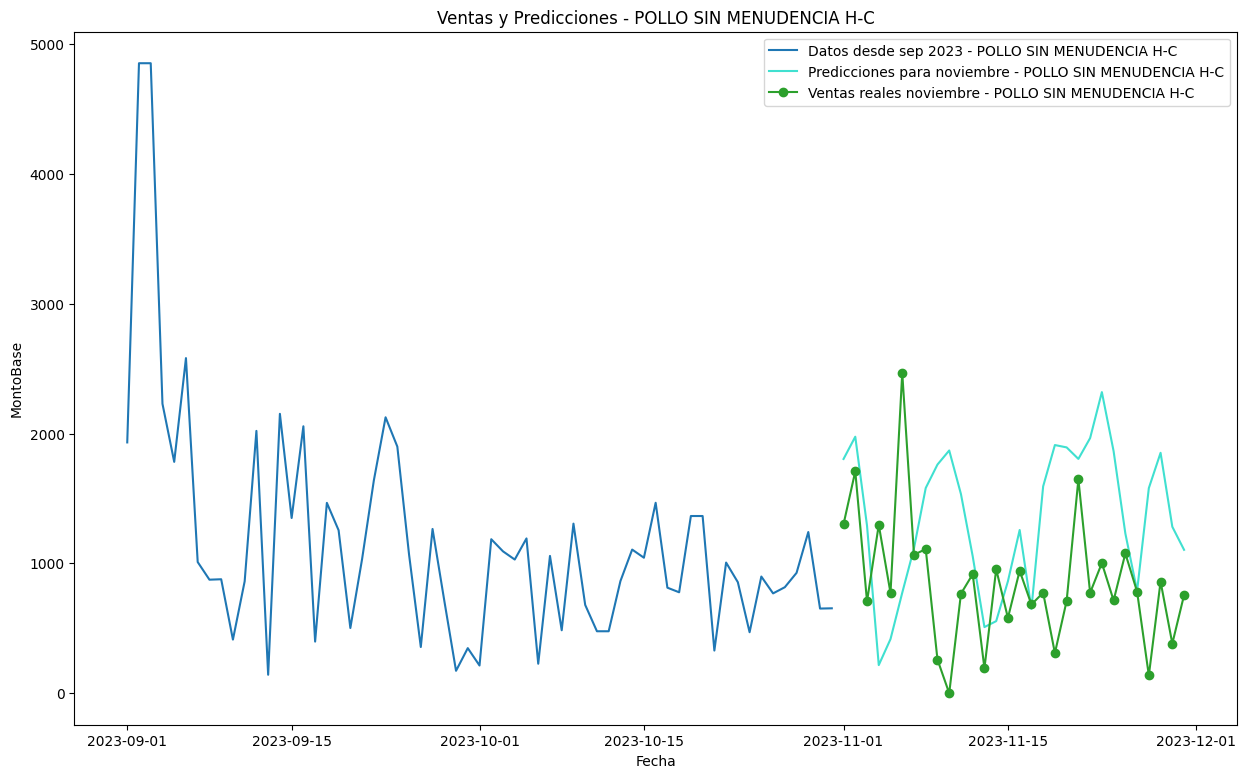

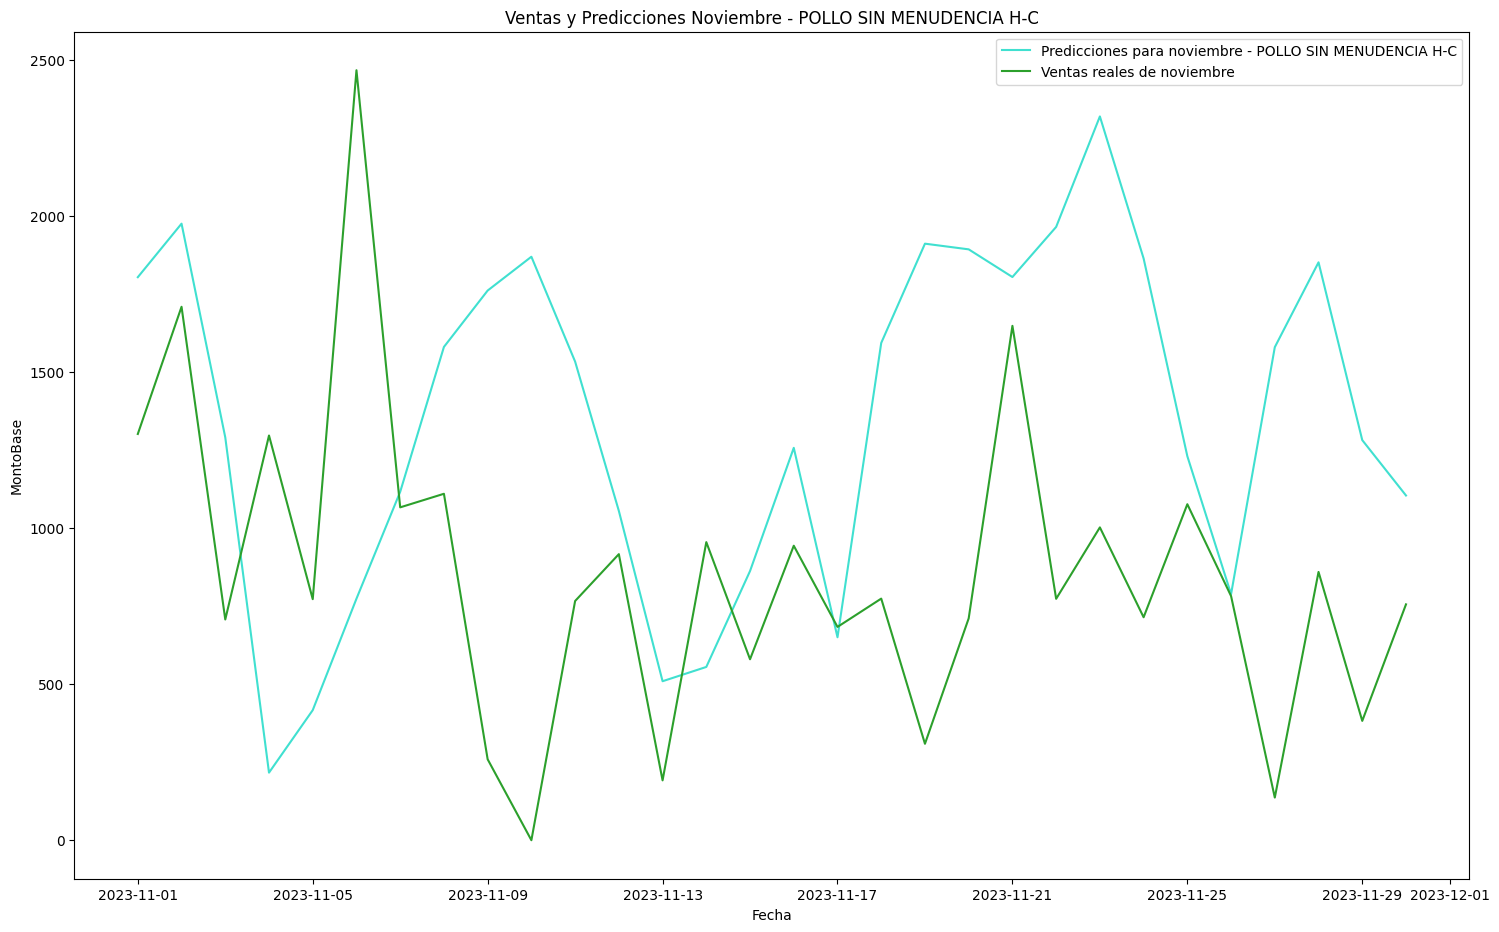

Longitud del producto - PIERNA MUSLO : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_4 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                           

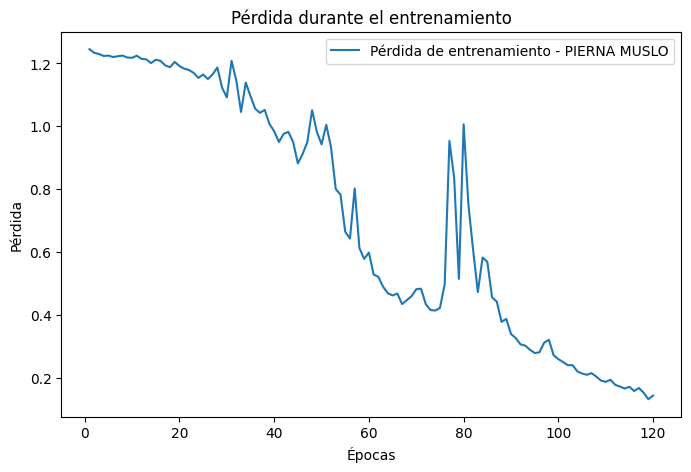

1/1 [==============================] - 1s 795ms/step
31


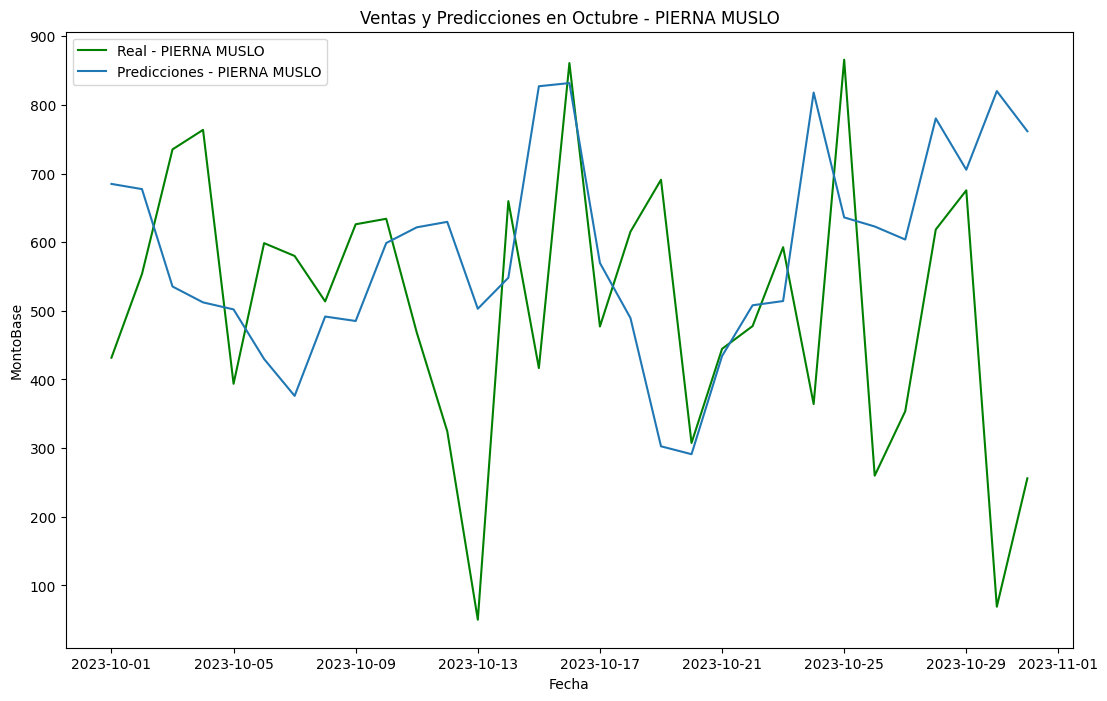

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 56ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_PIERNA MUSLO
FechaMovimiento                       
2023-11-01                    677.3010
2023-11-02                    535.4388
2023-11-03                    512.3235
2023-11-04                    502.0789
2023-11-05                    429.8620
2023-11-06                    376.1350
2023-11-07                    491.6955
2023-11-08                    485.2161
2023-11-09                    598.7357
2023-11-10                    621.6448
2023-11-11                    629.6136
2023-11-12                    503.0303
2023-11-13                    548.1910
2023-11-14                    827.1158
2023-11-15                    831.7562
2023-11-16                    569.7117
2023-11-17                    489.5264
2023-11-18                    302.7018

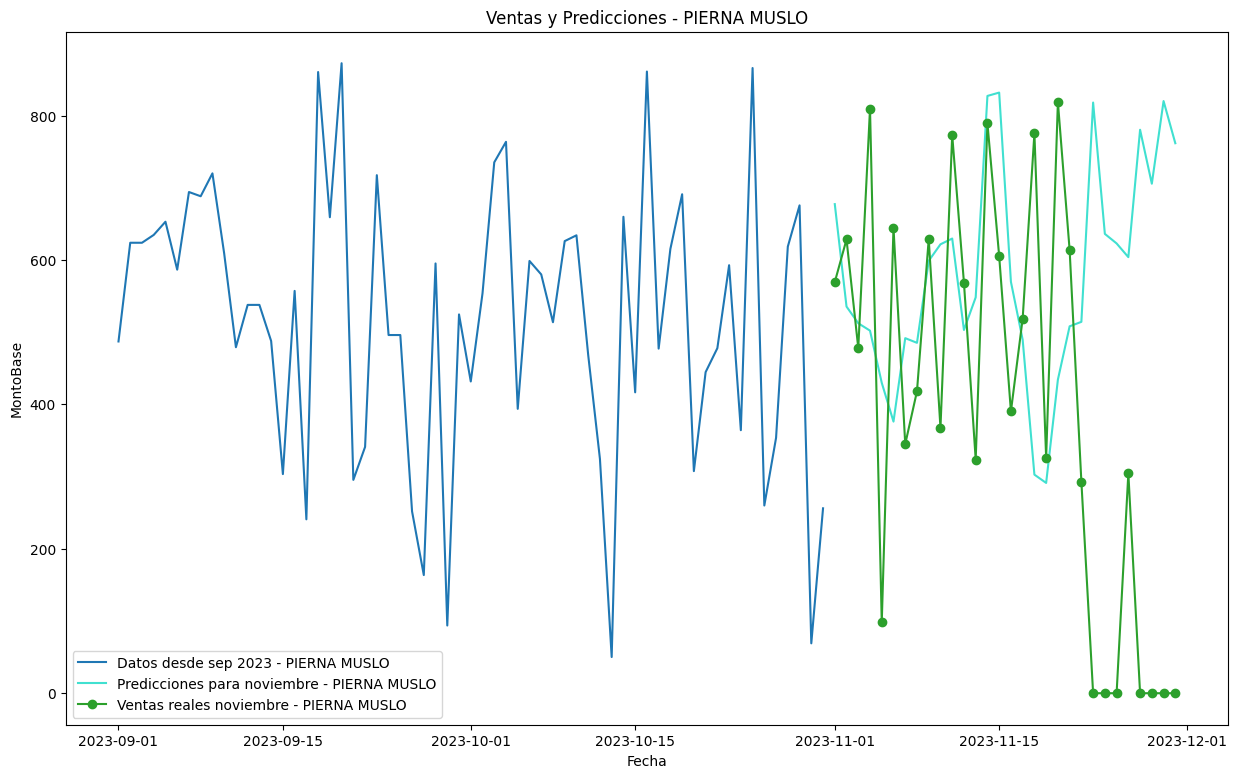

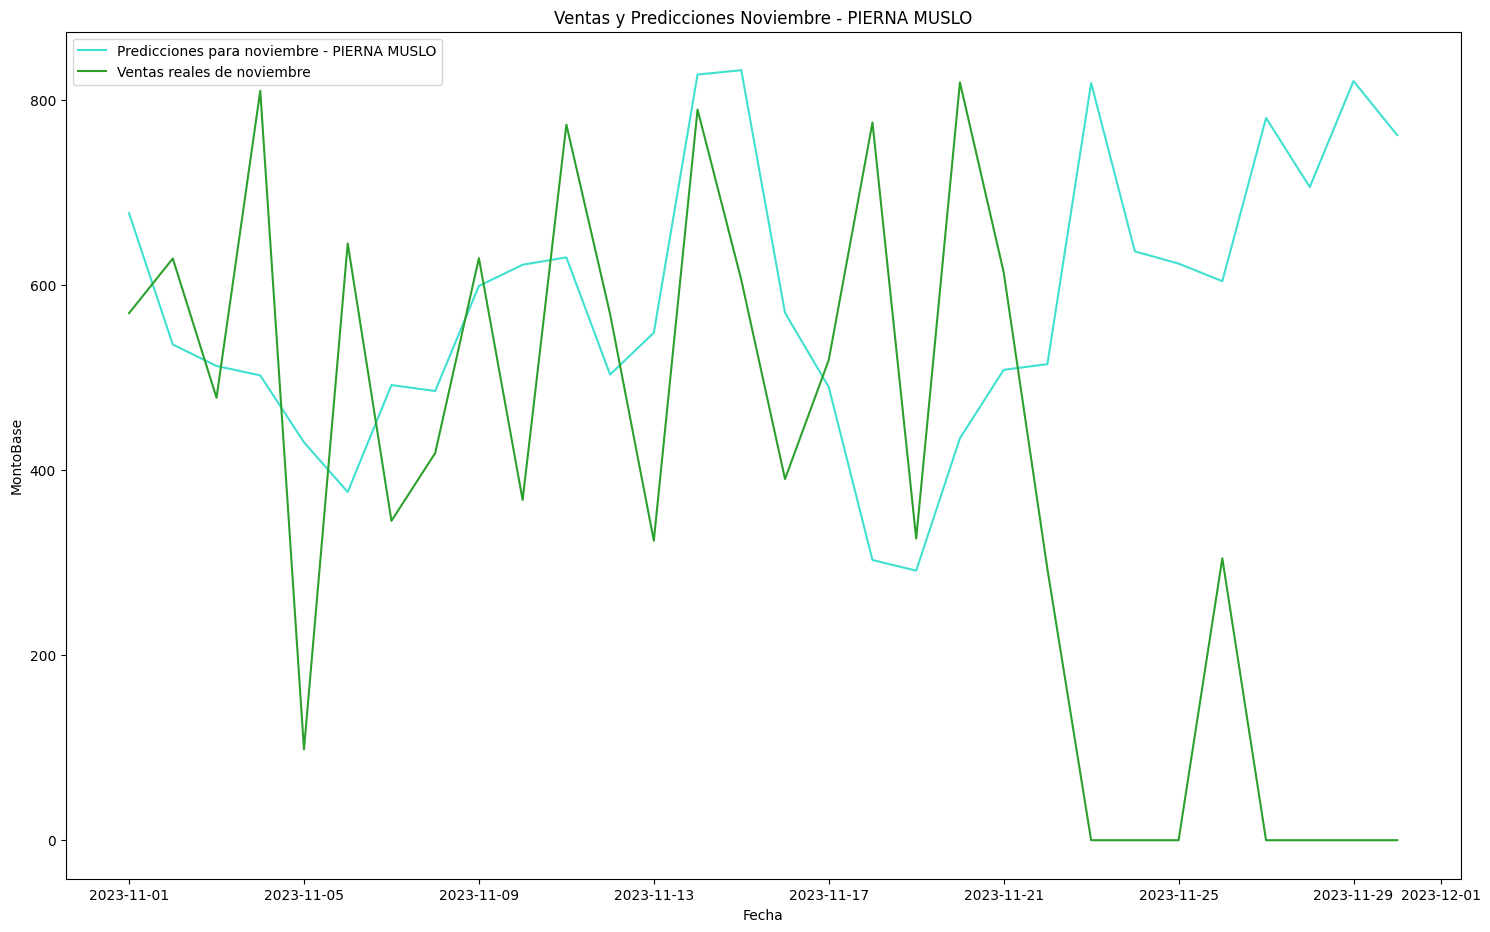

In [40]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

contador = 0
lstm_epochs = 10

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    contador += 1
    # Normalizar los datos
    scaler = RobustScaler()
    product_df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    time_steps = 30
    X, y = create_sequences_dwp(product_df_lstm['MontoBase_robust_scaler'].values, seq_length, time_steps)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) - 31)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    print(f"Longitud del producto - {product} :", product_df_lstm.shape)
    print("Forma de X:", X.shape)
    print("Forma de y:", y.shape)

    if contador == 1:
        lstm_epochs = 120
    elif contador == 2:
        lstm_epochs = 145
    elif contador == 3:
        lstm_epochs = 120

    # Construir el modelo LSTM
    model = Sequential()
    # 1º capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.2))

    # # 2º capa LSTM y Dropout para regularización.
    # model.add(LSTM(units = 100, return_sequences = True))
    # model.add(Dropout(rate=0.1))

    # 3ºa capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 200, return_sequences = False))
    model.add(Dropout(rate=0.2))

    # Capa de Salida!
    model.add(Dense(units = 100, activation='relu'))
    model.add(Dense(units = 1))
    # Resumen del modelo!
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Entrenar el modelo
    # history = model.fit(X_train, y_train, epochs=150, batch_size=30, verbose=1)
    history = model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=30, verbose=1)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    longitud_predicciones = len(predictions)
    print(longitud_predicciones)
    # fechas_predicciones = pd.date_range(start='2023-11-01', periods=len(predictions))
    # print(fechas_predicciones)
    # Visualizar las predicciones
    plt.figure(figsize=(13, 8))
    plt.plot(product_df_lstm['MontoBase'].tail(len(X_test)), label='Real - ' + product, color = 'green')
    plt.plot(product_df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones - ' + product)
    # plt.plot(product_df_lstm['MontoBase'], label='Real - ' + product)
    # plt.plot(product_df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones en Octubre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(90)  # Últimos 90 días

    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))
    print("La longitud de las prediccioes es: ", longitud_predicciones)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')
    input_data, _ = create_sequences_dwp(input_data, seq_length, time_steps)
    input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

    # Hacer predicciones para los siguientes 30 días
    predictions_future = model.predict(input_data)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 9))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # plt.style.use('seaborn')
    # sns.set_palette("Dark2")
    plt.figure(figsize=(18, 11))
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    # plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(dates_future, predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(real_november_data.index, real_november_data['MontoBase'], label='Ventas reales de noviembre', color = 'tab:green')
    plt.title('Ventas y Predicciones Noviembre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [41]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
FechaMovimiento                                                          
2023-11-01       POLLO ESPECIAL  1999.7321                   1904.6724   
2023-11-02       POLLO ESPECIAL  1011.2892                   1719.1750   
2023-11-03       POLLO ESPECIAL  2343.7883                   1942.6333   
2023-11-04       POLLO ESPECIAL  1673.2089                   2324.3057   
2023-11-05       POLLO ESPECIAL  1181.9289                   1750.9780   
2023-11-06       POLLO ESPECIAL   863.7984                   1887.0078   
2023-11-07       POLLO ESPECIAL  1648.4580                   1746.5221   
2023-11-08       POLLO ESPECIAL  1434.6711                   1821.5955   
2023-11-09       POLLO ESPECIAL  16

## Evaluar LSTM




In [42]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 962450.8400167909
MAE is : 808.5555872233073
R2 is : -1.649914790476993 %
------------------------------
MRSE is : 981.045788950134
MAPE is : 117.26613944209039 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 833576.9263388544
MAE is : 729.6298768326823
R2 is : -2.411990931791378 %
------------------------------
MRSE is : 913.0043408105212
MAPE is : 140.868922027509 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 163113.93704063256
MAE is : 306.98127563476567
R2 is : -1.0813138349049867 %
------------------------------
MRSE is

# ARIMA

In [61]:
!pip install pmdarima

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

Predicciones para POLLO ESPECIAL:


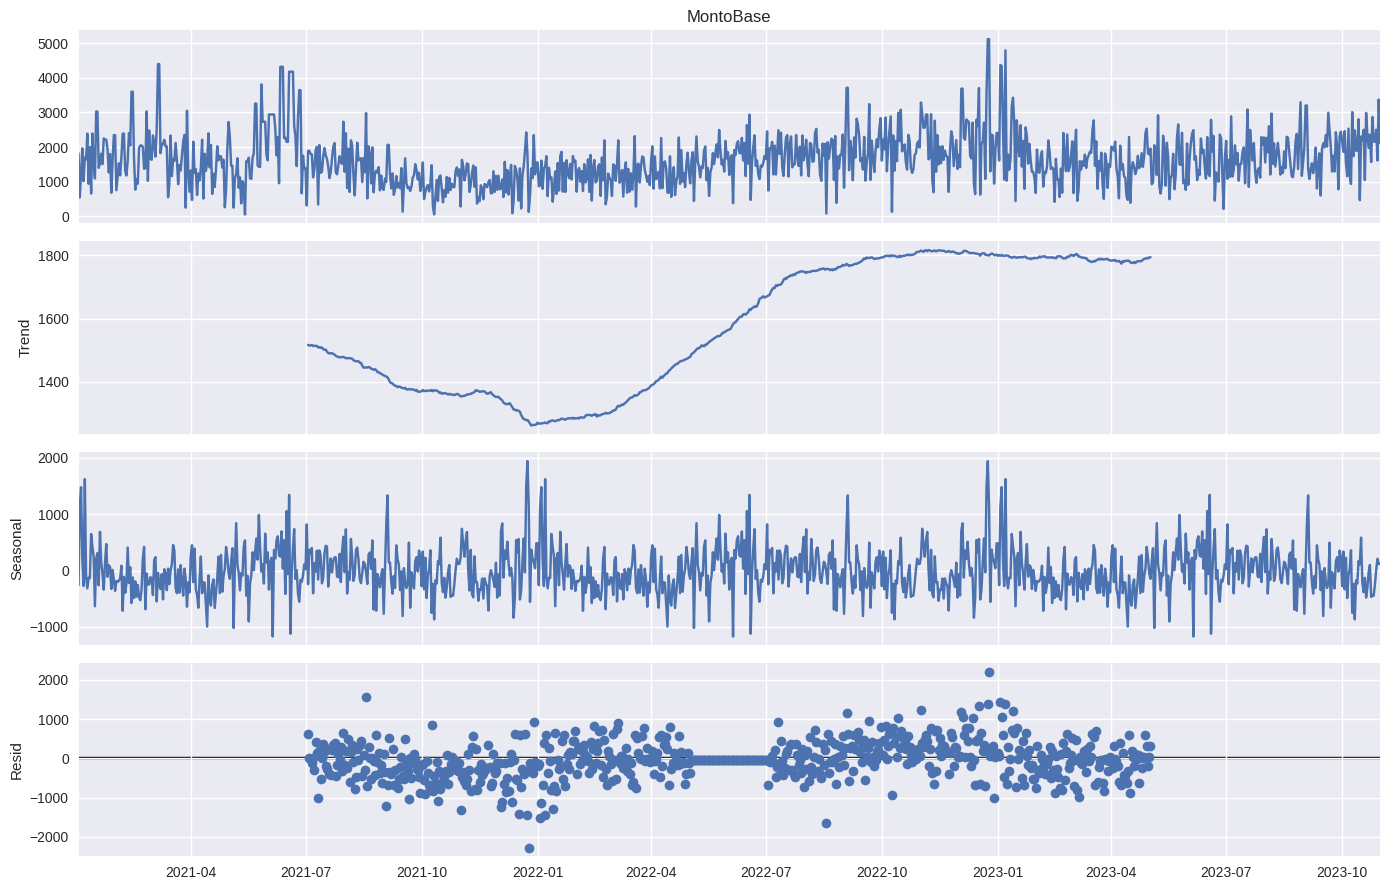

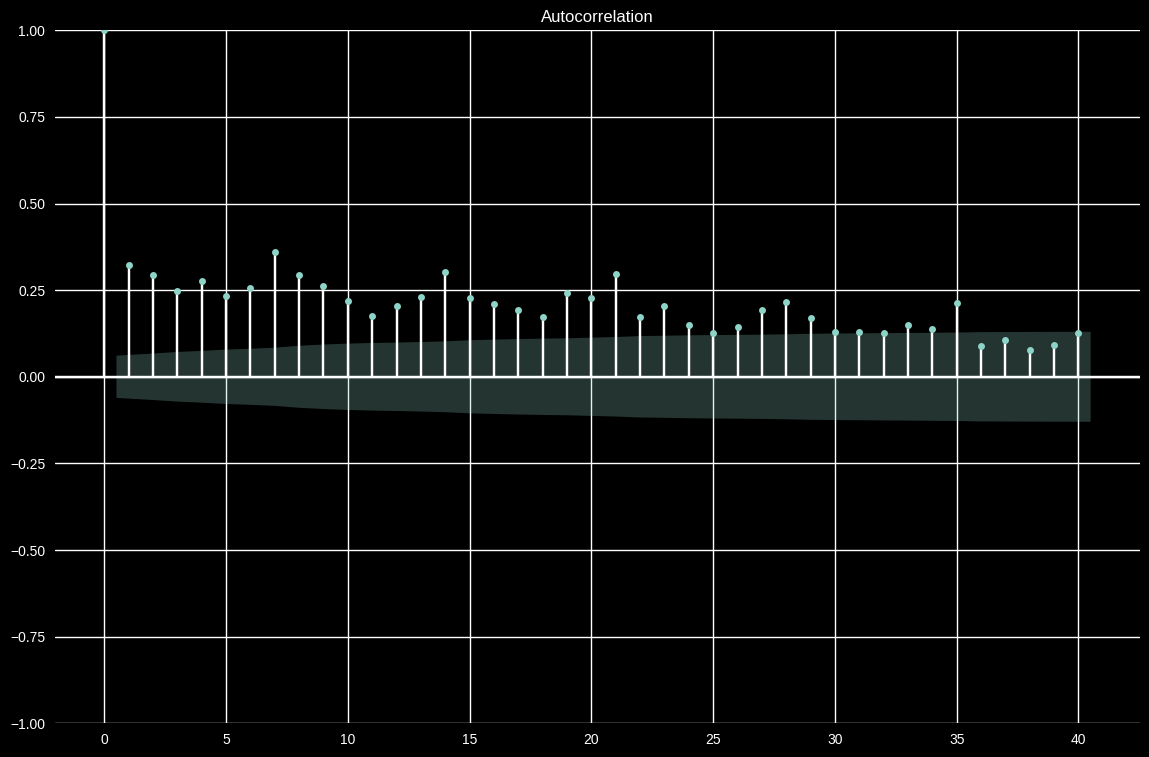

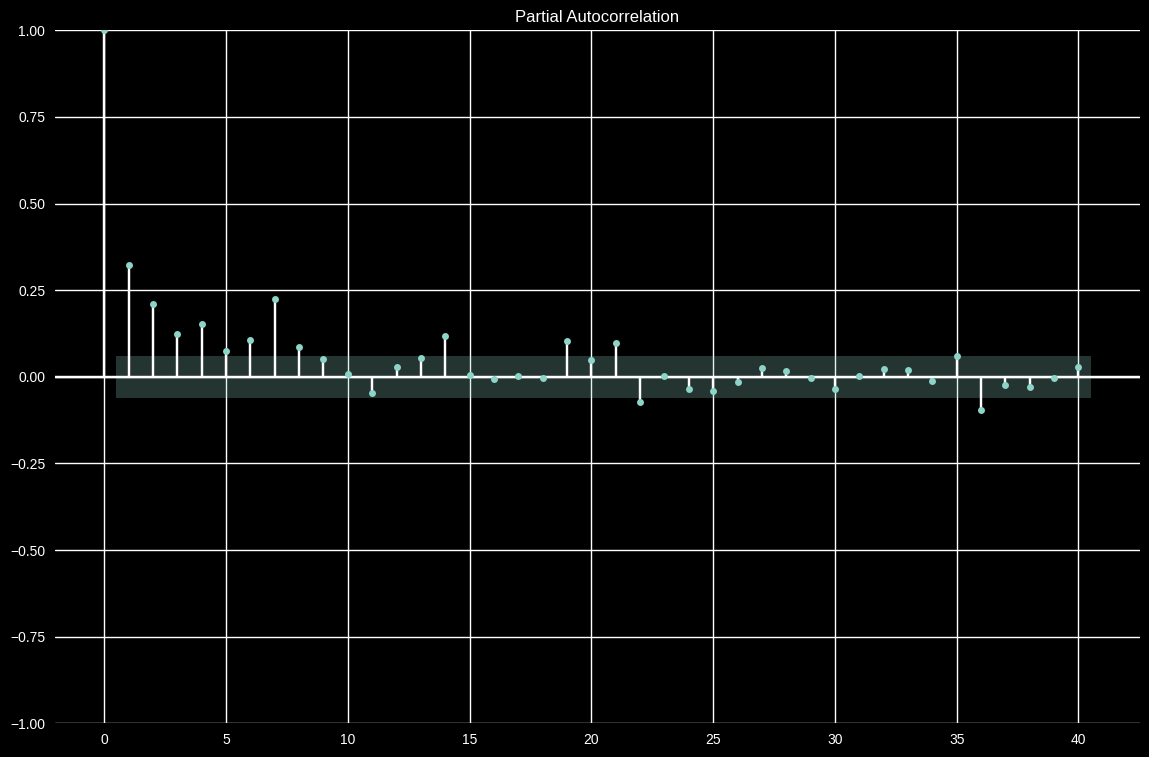

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-63-8fd0a4fbbf4b>:94: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplot

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01   2190.2432
2023-10-02   2073.1816
2023-10-03   2065.2084
2023-10-04   2422.3776
2023-10-05   1107.6153
2023-10-06   1539.4423
2023-10-07   1726.9371
2023-10-08   2027.5143
2023-10-09   2229.1458
2023-10-10   1446.8099
2023-10-11   1900.7804
2023-10-12   2068.7084
2023-10-13   2024.1266
2023-10-14   2181.0558
2023-10-15   1999.9503
2023-10-16   2224.1499
2023-10-17   1105.3707
2023-10-18   1544.4251
2023-10-19   1657.7771
2023-10-20   1810.2520
2023-10-21   2035.8396
2023-10-22   1440.2088
2023-10-23   2078.9932
2023-10-24   2224.5870
2023-10-25   2118.0525
2023-10-26   2371.7585
2023-10-27   2107.4047
2023-10-28   2268.9098
2023-10-29   1172.3437
2023-10-30   1562.5715
Freq: D, Name: ARIMA Predictions POLLO ESPECIAL, dtype: float64

Ventas reales y predicciones ARIMA para POLLO ESPECIAL:
                 MontoBase  P-V_ARIMA_POLLO ESPECIAL
FechaMovimie

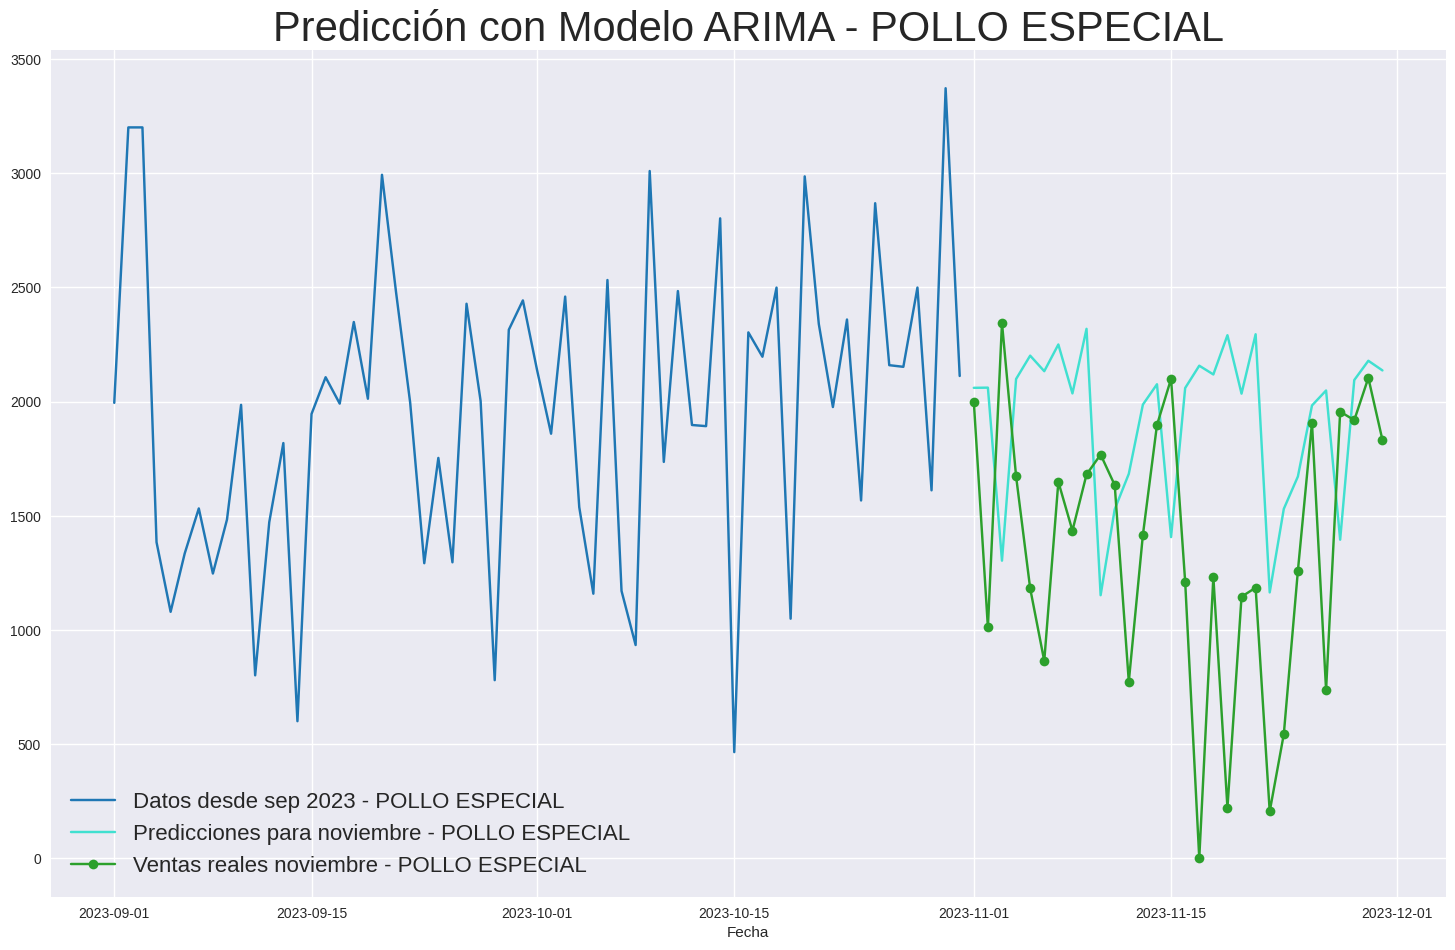

<ipython-input-63-8fd0a4fbbf4b>:112: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


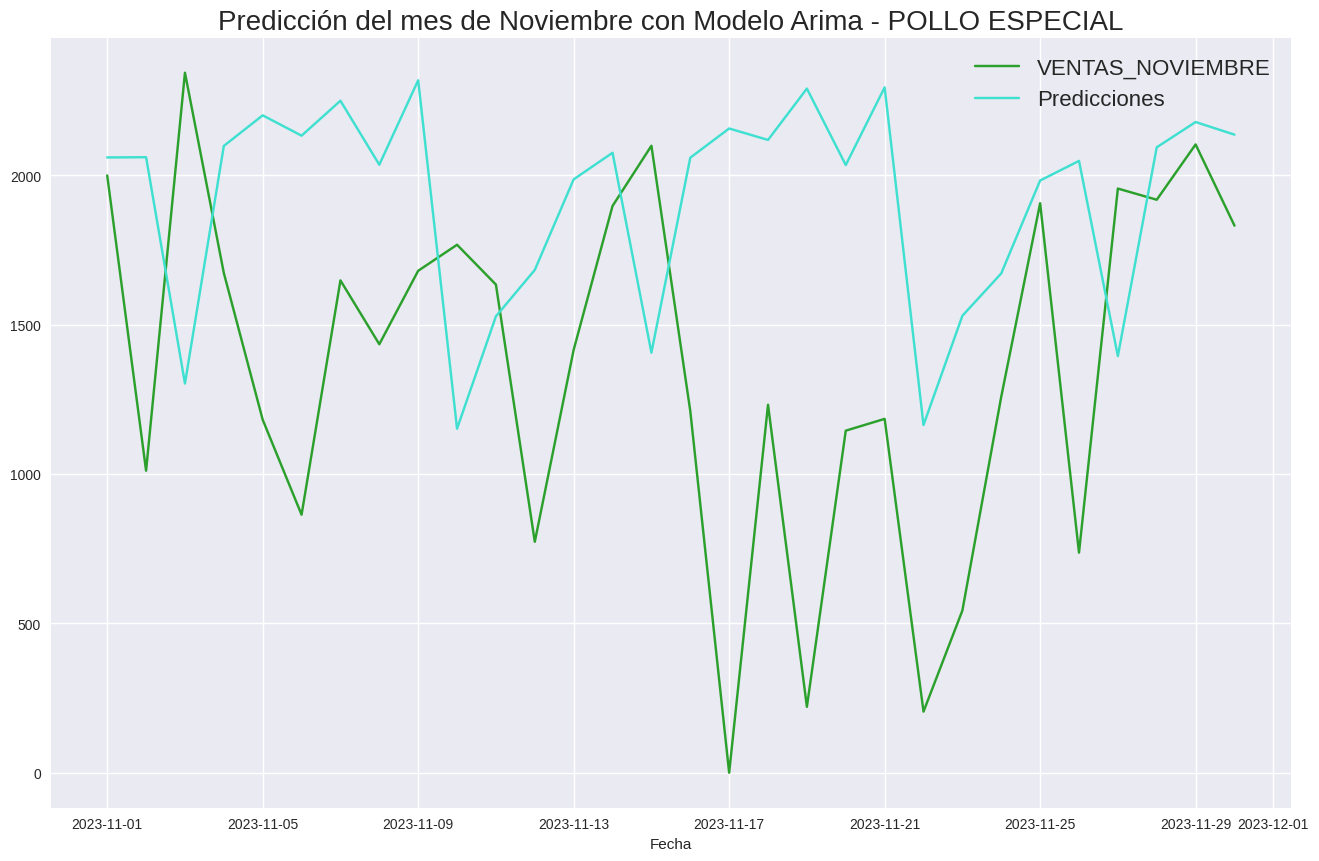

Predicciones para POLLO SIN MENUDENCIA H-C:


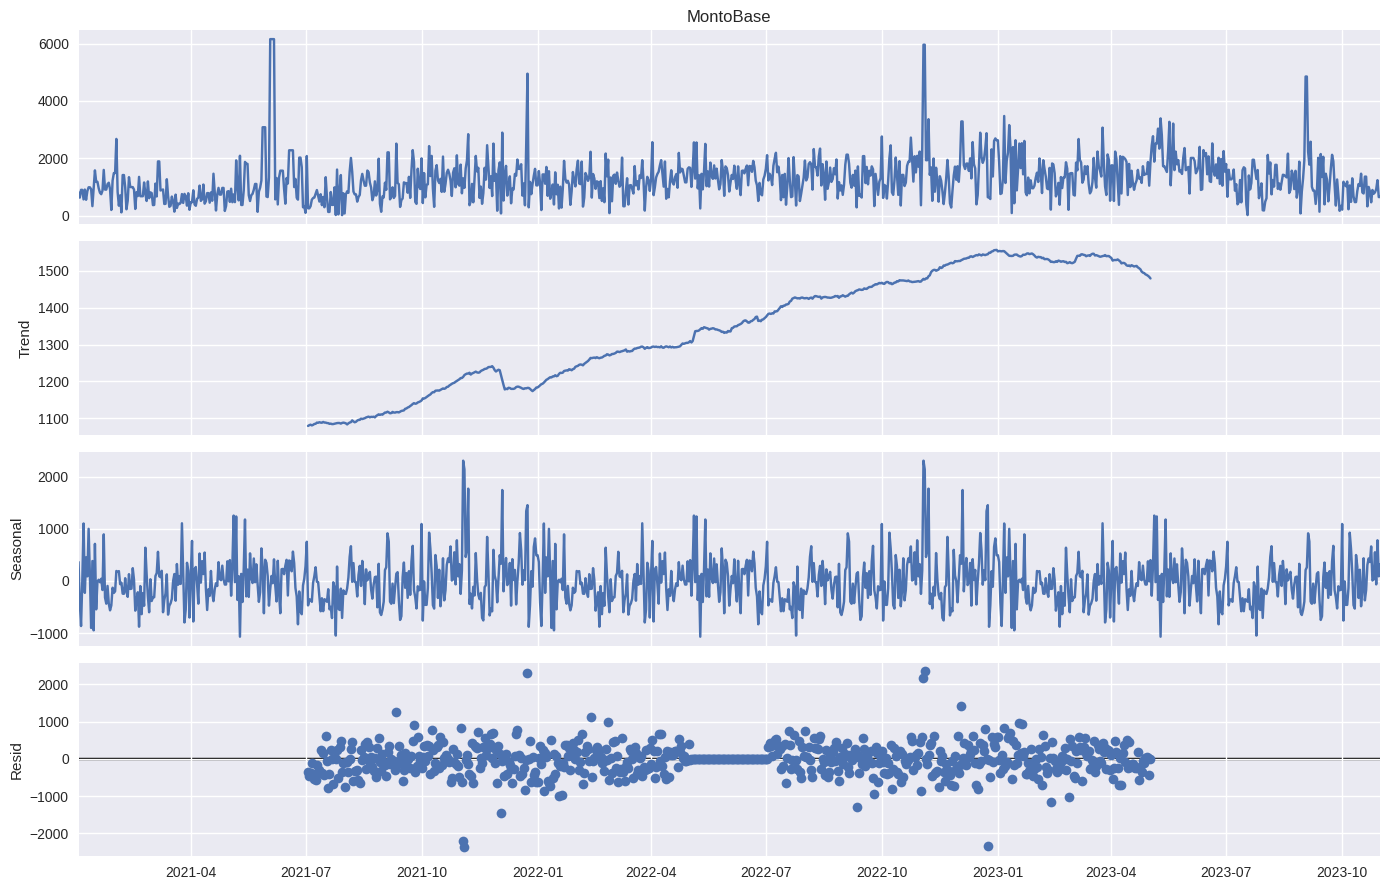

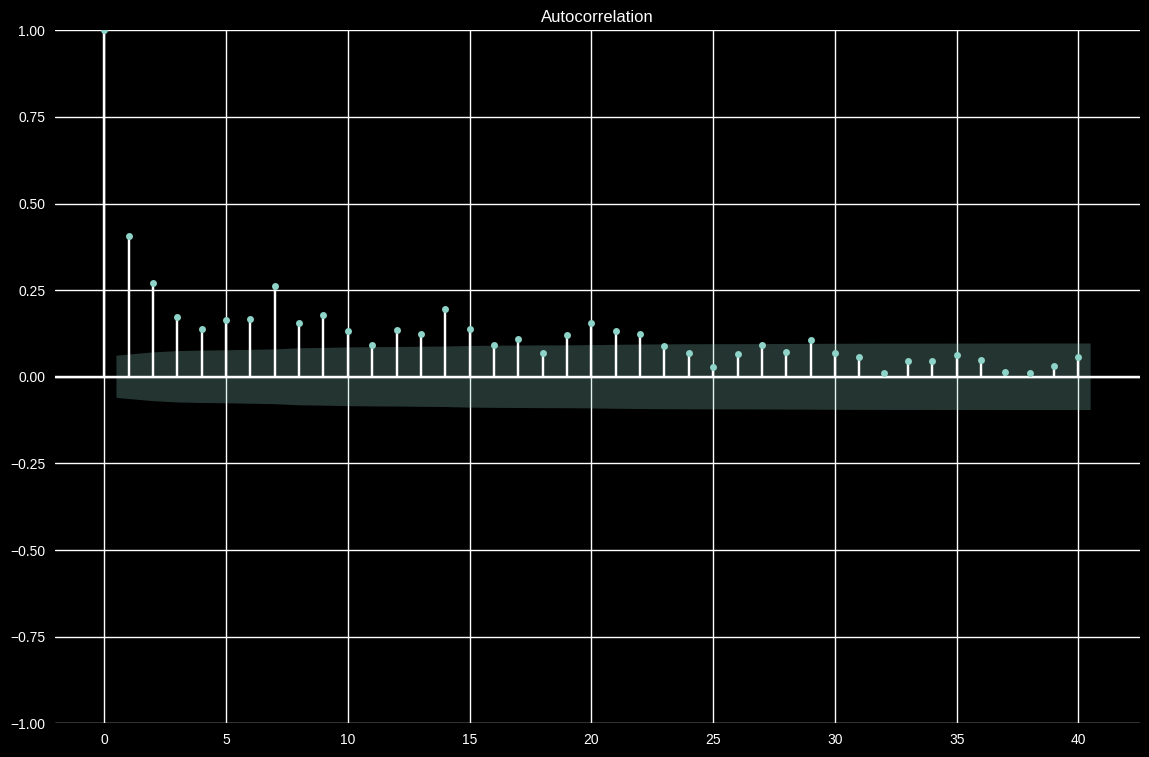

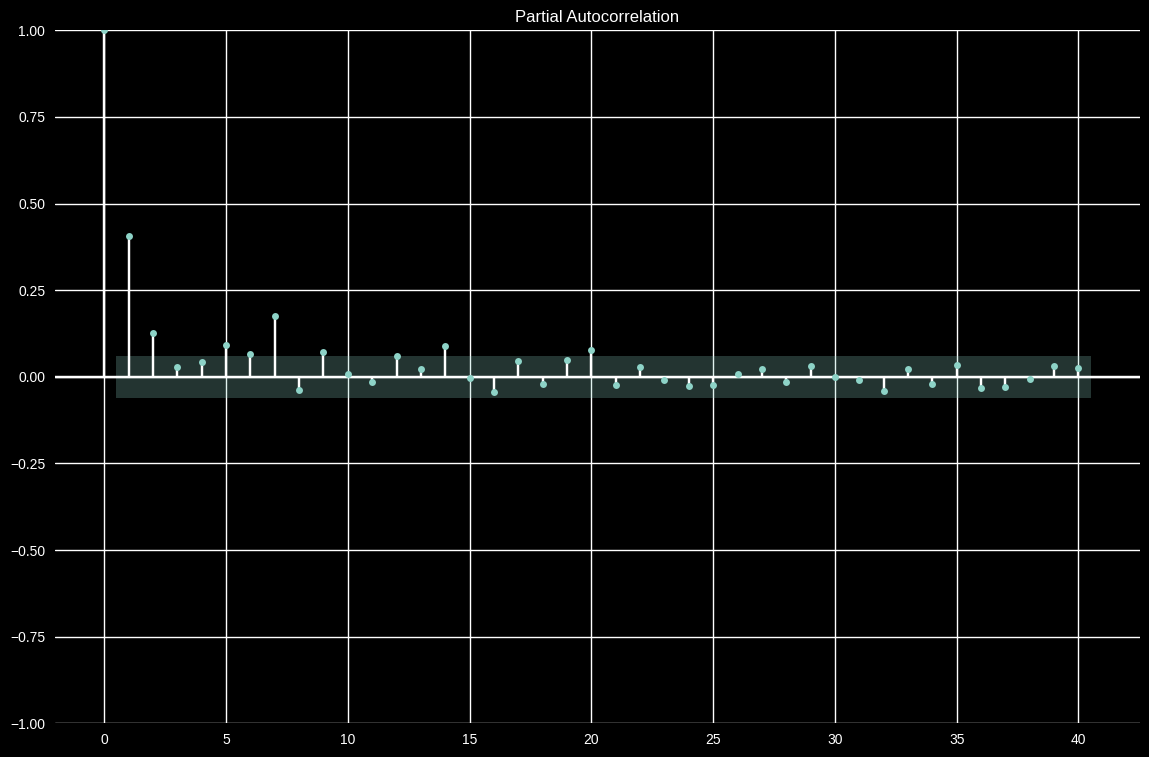

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-63-8fd0a4fbbf4b>:94: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplot

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01    535.4208
2023-10-02    910.1540
2023-10-03   1064.5993
2023-10-04    717.4396
2023-10-05    809.8729
2023-10-06   1348.0833
2023-10-07    690.0641
2023-10-08   1809.6695
2023-10-09   2001.8788
2023-10-10   1283.3904
2023-10-11    747.9867
2023-10-12   1215.4954
2023-10-13    801.5242
2023-10-14    780.4442
2023-10-15   1124.9324
2023-10-16    747.4625
2023-10-17   1124.4602
2023-10-18   1674.7006
2023-10-19    825.2537
2023-10-20   1834.3418
2023-10-21   2067.2073
2023-10-22   1458.8150
2023-10-23    737.8290
2023-10-24   1351.6998
2023-10-25    810.9243
2023-10-26    747.0398
2023-10-27   1198.4012
2023-10-28    679.0230
2023-10-29   1147.9193
2023-10-30   1597.2293
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO S

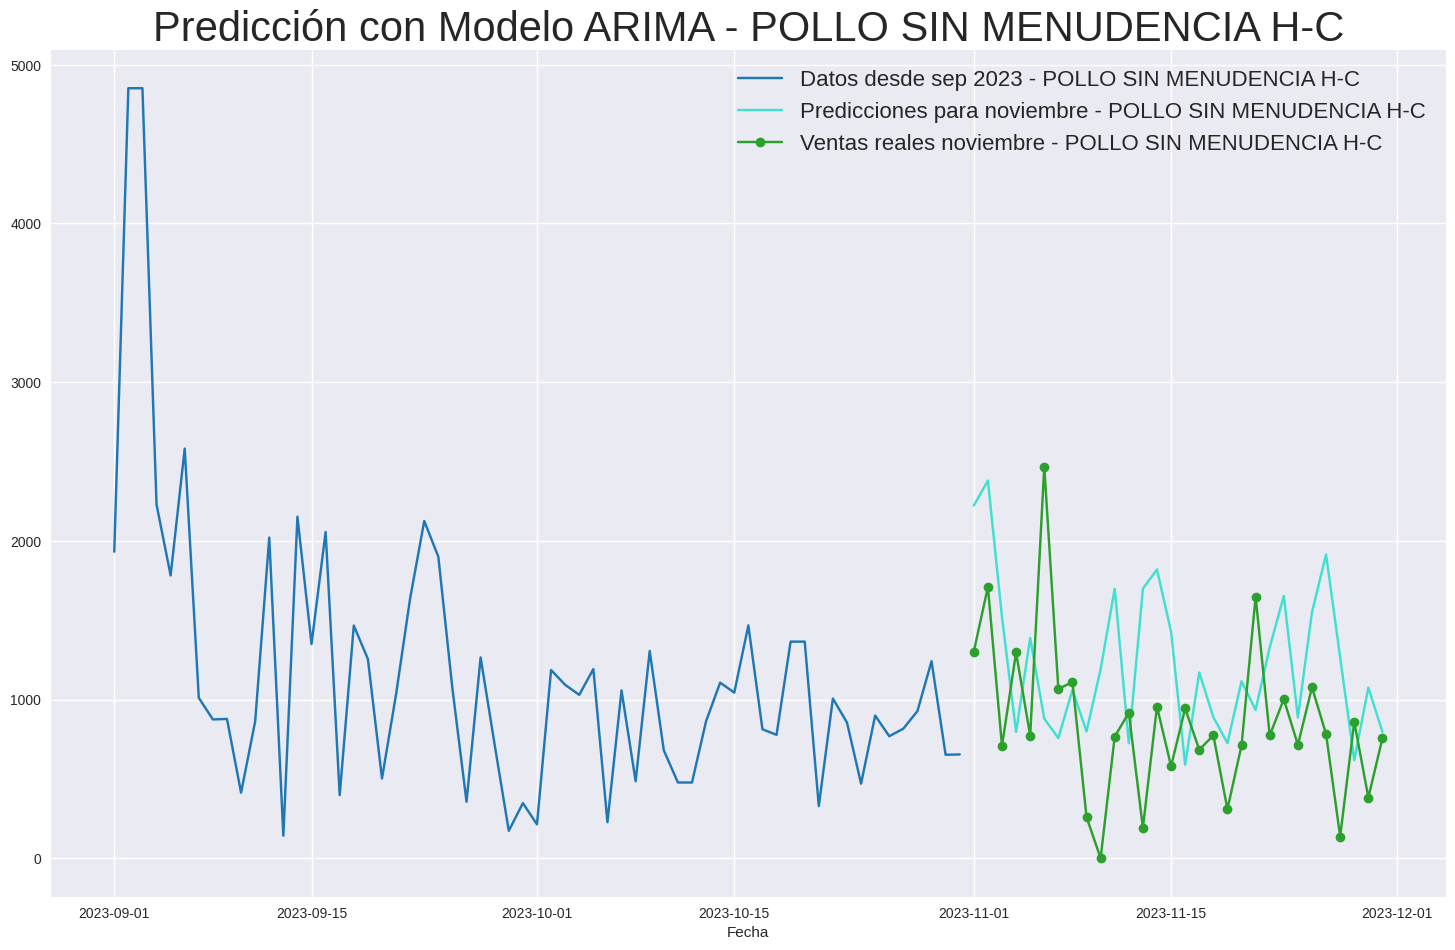

<ipython-input-63-8fd0a4fbbf4b>:112: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


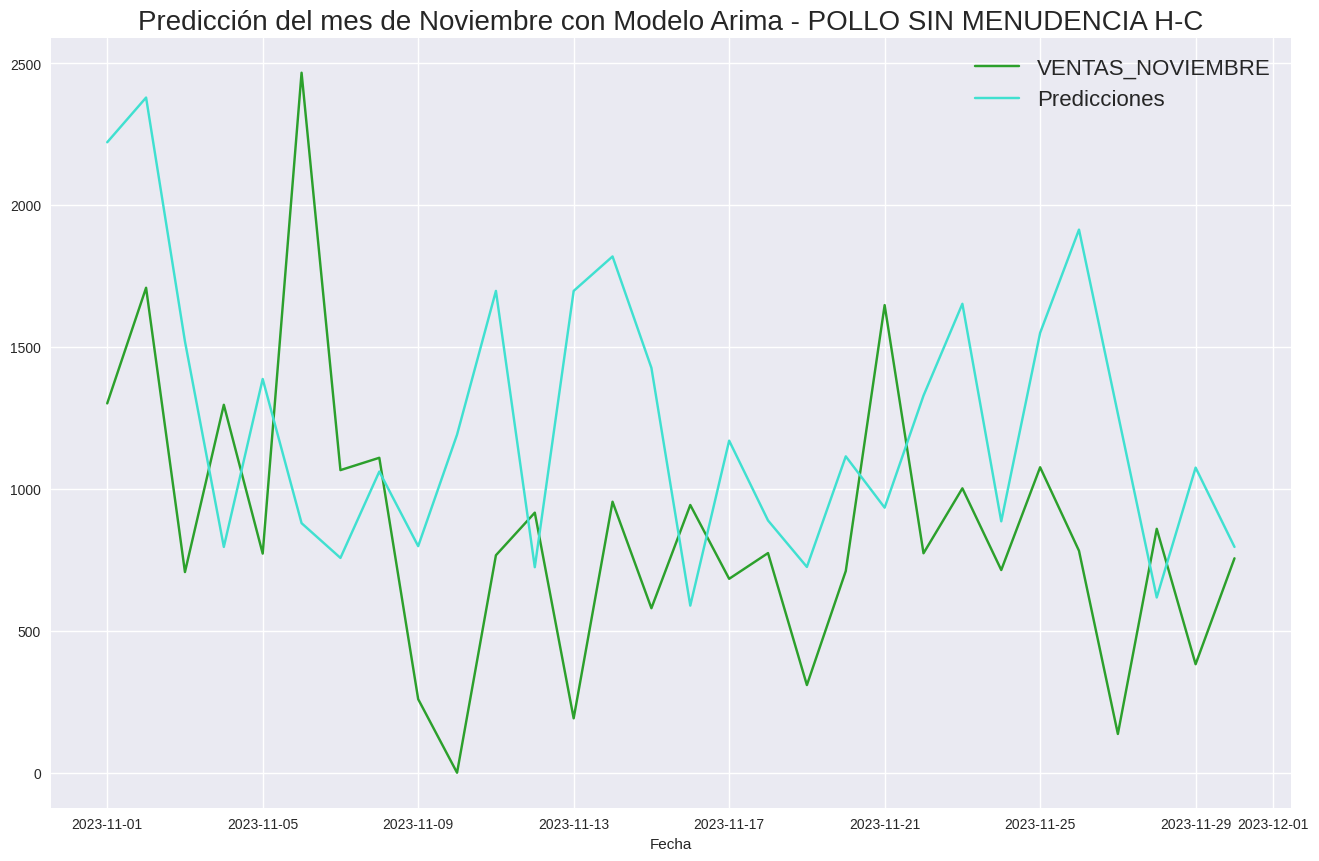

Predicciones para PIERNA MUSLO:


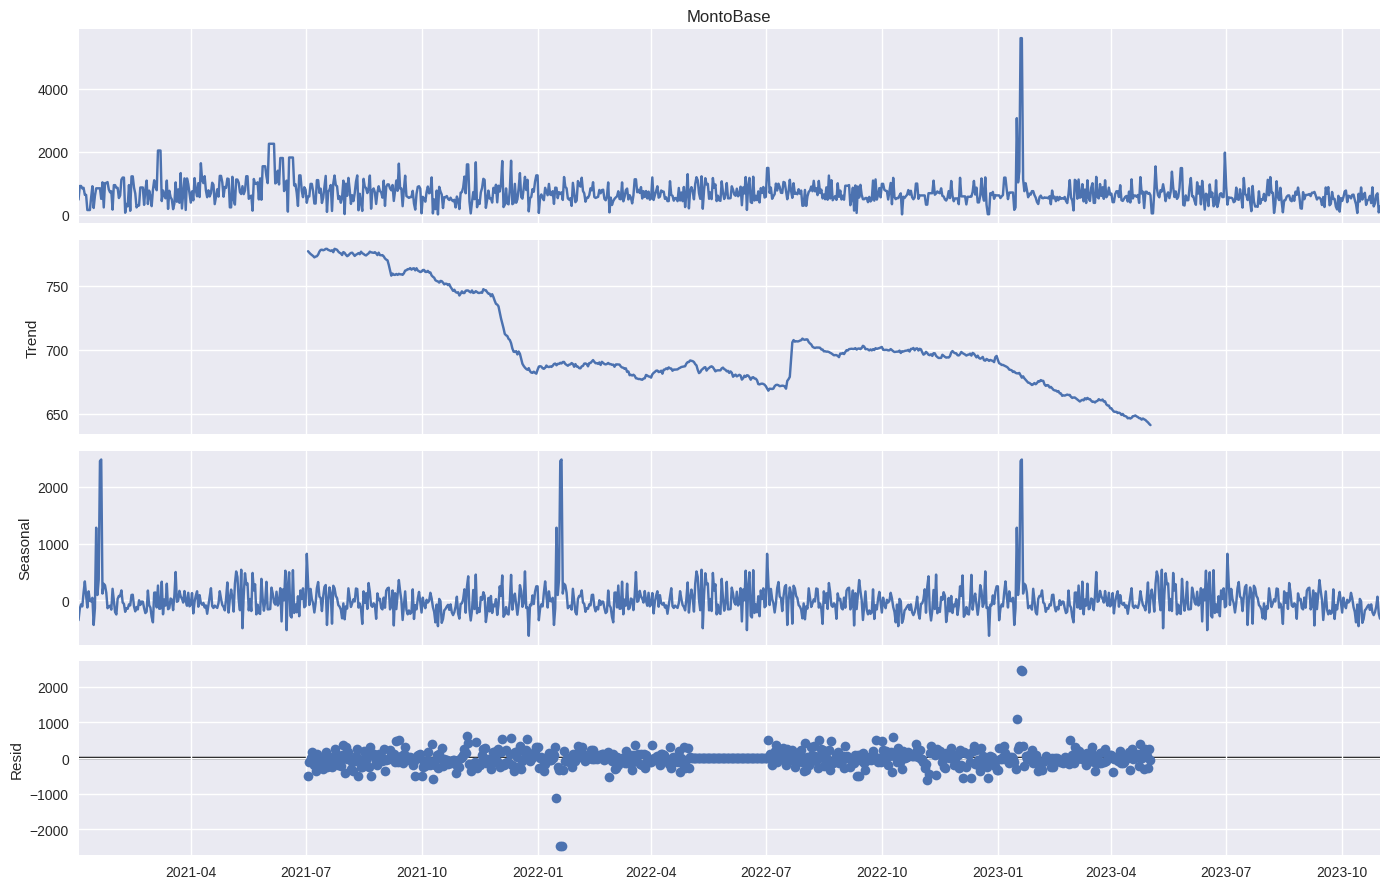

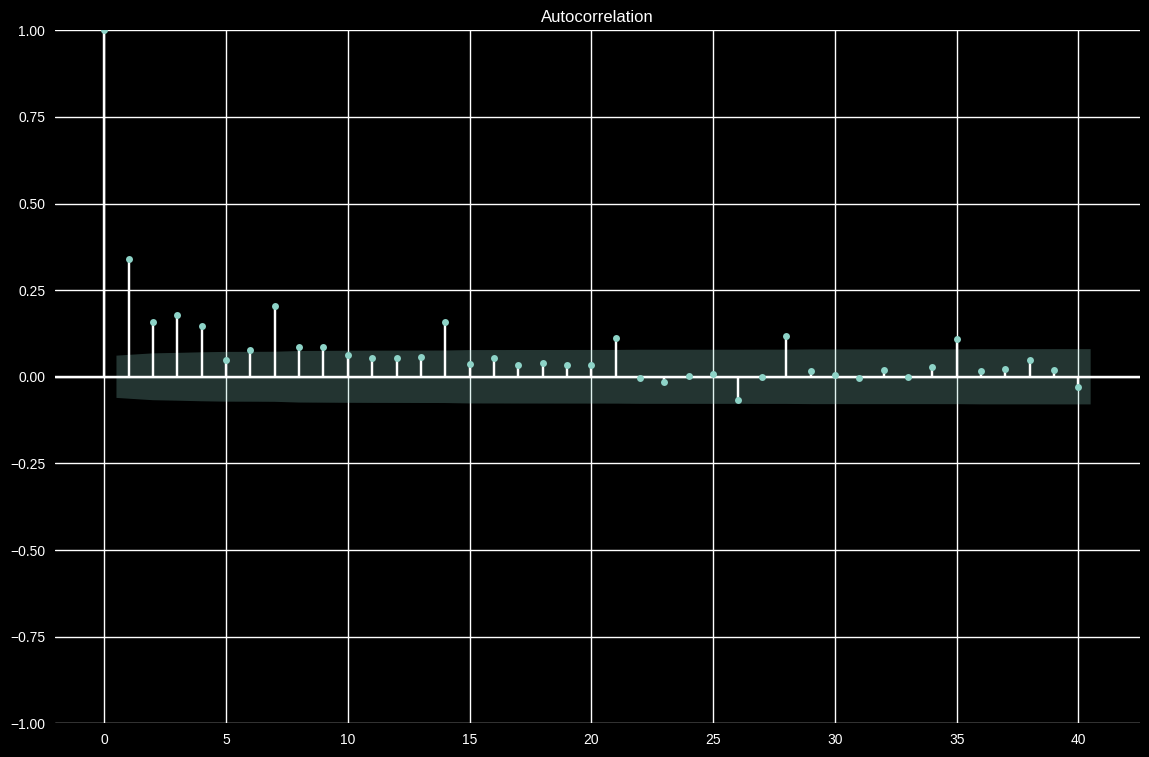

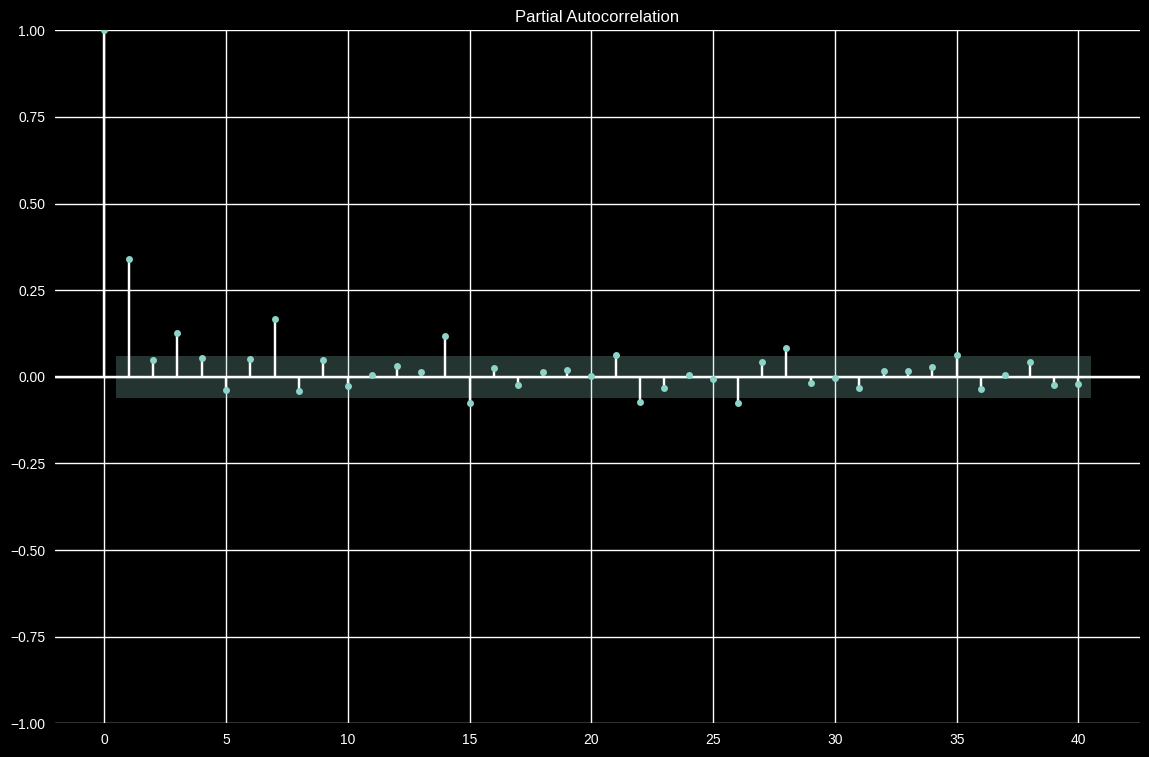

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-63-8fd0a4fbbf4b>:94: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.u

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01   578.7036
2023-10-02   647.5221
2023-10-03   422.8795
2023-10-04   725.2200
2023-10-05   531.5204
2023-10-06   425.2861
2023-10-07   619.6052
2023-10-08   460.9937
2023-10-09   504.3059
2023-10-10   528.1753
2023-10-11   482.7346
2023-10-12   567.1838
2023-10-13   511.3930
2023-10-14   715.1388
2023-10-15   476.6640
2023-10-16   537.7803
2023-10-17   464.5221
2023-10-18   455.9022
2023-10-19   594.1341
2023-10-20   432.3650
2023-10-21   514.5259
2023-10-22   530.7497
2023-10-23   496.4614
2023-10-24   586.1328
2023-10-25   523.2963
2023-10-26   756.9170
2023-10-27   503.4321
2023-10-28   597.4980
2023-10-29   496.6493
2023-10-30   527.3557
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
                 MontoBase  P-V_ARIMA_PIERNA MUSLO
FechaMovimiento                                 

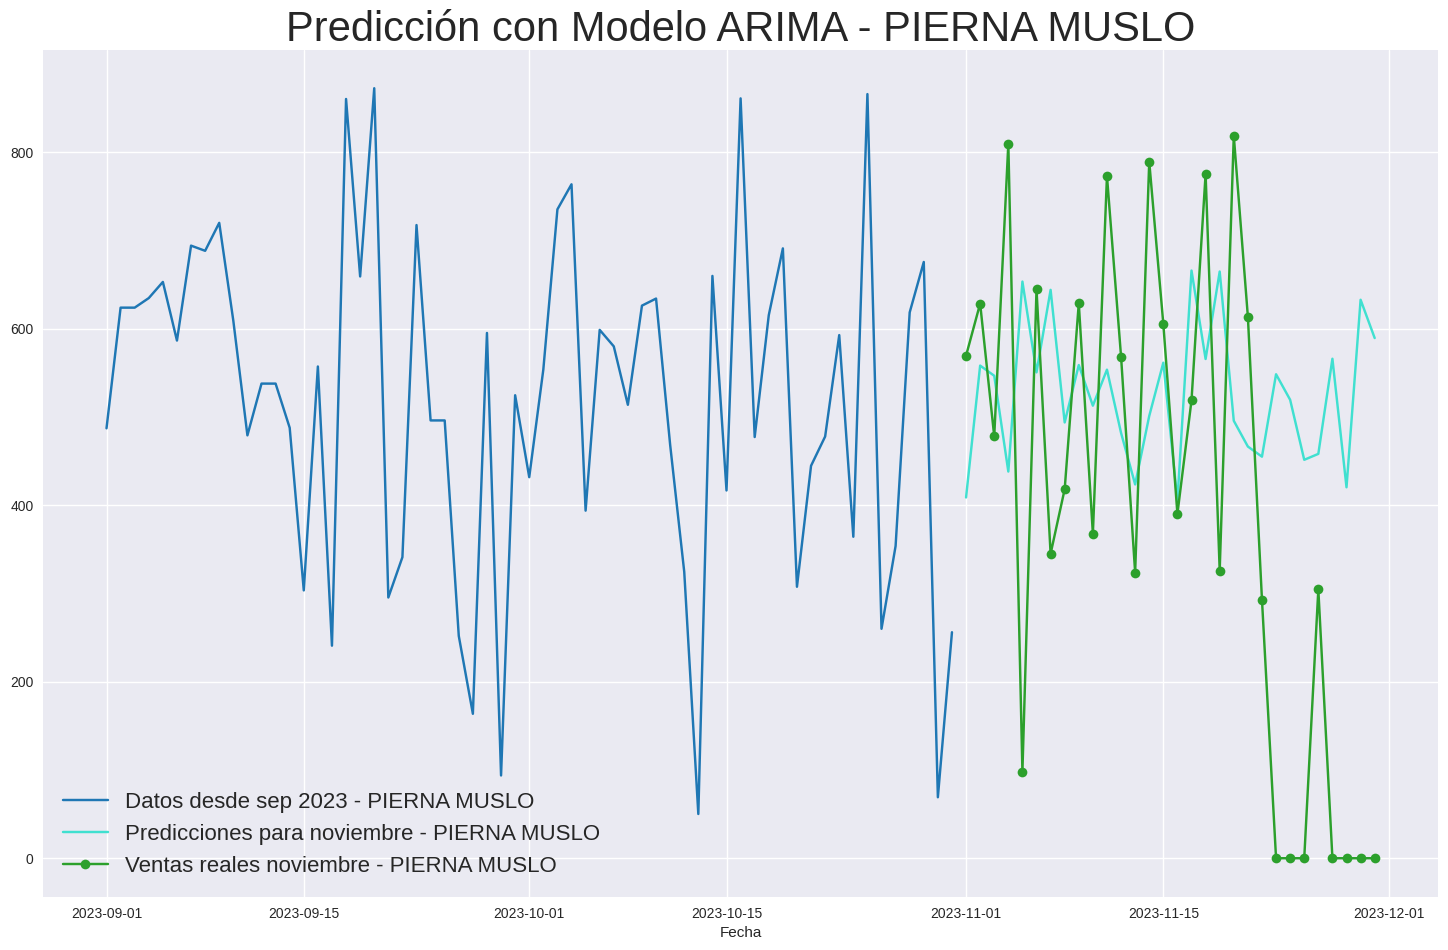

<ipython-input-63-8fd0a4fbbf4b>:112: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


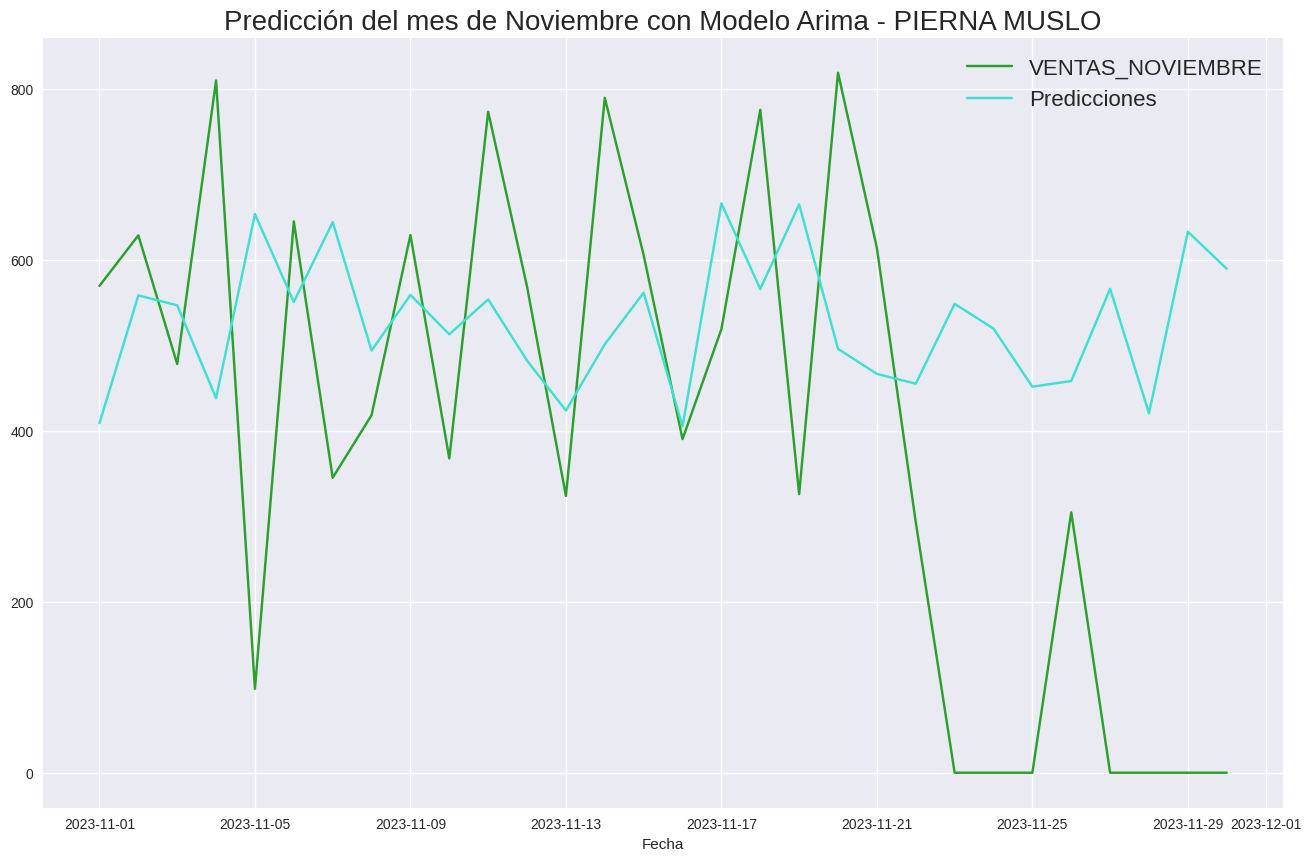

In [63]:
# Configurar tamaño de las figuras


# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

contador = 0
vp, vd, vq = 0, 0, 0
vP, vD, vQ = 0, 0, 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    contador += 1

    # Aquí puedes poner el código para realizar la predicción con ARIMA
    print(f"Predicciones para {product}:")
    plt.rcParams["figure.figsize"] = (14, 9)
    # Realizar descomposición estacional
    decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
    decomposition.plot();
    plt.show()
    # Visualizar ACF y PACF
    plt.style.use('dark_background')
    plot_acf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    plot_pacf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    # Dividir en orden cronológico, entrenando sin el mes de octubre
    train_size_arima = int(len(product_df_arima) - 31)
    train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

    print(train_arima.shape, test_arima.shape)

    if contador == 1:
        vp, vd, vq = 4, 1, 3
        vP, vD, vQ = 2, 1, 0
    elif contador == 2:
        vp, vd, vq = 8, 1, 3
        vP, vD, vQ = 4, 1, 0
    elif contador == 3:
        vp, vd, vq = 6, 1, 1
        vP, vD, vQ = 7, 1, 0

    # # Identificar el modelo ARIMA automáticamente
    # modelo_auto = auto_arima(train_arima['MontoBase'],
    #                       start_p=6, d=1, start_q=0,
    #                       max_p=10, max_d=3, max_q=5,
    #                       start_P=3, D=1, start_Q=0,
    #                       max_P=4, max_D=2, max_Q=2,
    #                       seasonal=True, m=12, trace=True,
    #                       error_action='ignore', suppress_warnings=True, stepwise=True,
    #                       random_state=20, n_fits=50
    #                       )
    # print(modelo_auto.summary())
    # # Configurar el modelo ARIMA
    # arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)

    arima_model = SARIMAX(train_arima["MontoBase"], order=(vp, vd, vq), seasonal_order=(vP, vD, vQ, 12))
    arima_result = arima_model.fit()
    arima_models[product] = arima_result  # Guardar el modelo en el diccionario

    # Hacer predicciones con ARIMA
    arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
    # Crear un índice para las predicciones de noviembre
    november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
    arima_pred.index = november_index

    print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
    print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

    # Imprimir las predicciones para el mes de noviembre
    print(arima_pred)

    # Agregar las predicciones al DataFrame original
    if product in arima_models:
        # Hacer predicciones con ARIMA para el DataFrame actual
        arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

        # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
        arima_pred_full.index = dfs_noviembre_sumados[product].index

        # Agregar la columna de predicciones ARIMA al DataFrame actual
        dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

        # Imprimir el resultado
        print(f'\nVentas reales y predicciones ARIMA para {product}:')
        print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(15))
    else:
        print(f"No hay modelo ARIMA para {product}.")

    # Visualizar las predicciones y los datos reales
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (18, 11)
    # Datos de venta desde el 1ro de septiembre de 2023
    # Convertir la cadena a un objeto datetime.date
    start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
    plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
    plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color='turquoise', label='Predicciones para noviembre - ' + product)
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (16, 10)
    dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"]
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]["MontoBase"], color="tab:green" ,label="VENTAS_NOVIEMBRE")
    plt.plot(dfs_noviembre_sumados[product].index,dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"], color = 'turquoise', label="Predicciones")
    plt.title(f"Predicción del mes de Noviembre con Modelo Arima - {product}", fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

In [64]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229   
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895   
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652   
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834   
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420   
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758   
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938   
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792   
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104   
2023-11-10       POLLO SIN MENUDENCIA H-C     0.0000   
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036   
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644   
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683   
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658   
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350   
2023-11-16       POLLO SIN MENUDENCIA H-C   943.

## Evaluar ARIMA

In [65]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 830239.4728663177
MAE is : 753.4478384922022
R2 is : -1.2858973854164808 %
------------------------------
MRSE is : 911.174776245654
MAPE is : 101.47513585920495 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 561995.0474649883
MAE is : 637.2224445715844
R2 is : -1.3003539866250091 %
------------------------------
MRSE is : 749.6632893939708
MAPE is : 122.83474273849993 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 104582.20981002023
MAE is : 262.3912062927359
R2 is : -0.33445617285486007 %
------------------------------
MRS

VALORES CON TRAIN -31


**P1 - POLLO ESPECIAL**  OBJETIVO
+ MRSE is : 926.1379606313575
+ MAPE is : 103.3570196515878 %
- RECOMENDADO POR AUTO_ARIMA
  - ARIMA(8,1,0)(4,1,0)
    - MRSE is : 1021.4004131302385
    - MAPE is : 118.57070091824605 %
___
- ARIMA(4,1,3)(2,1,0)
  + MRSE is : 911.174776245654
  + MAPE is : 101.47513585920495 %
___
- ARIMA(9,1,0)(4,1,0)
- valores un poco elevados
  + MRSE is : 1019.896367568696
  + MAPE is : 118.34992562982445 %
- ARIMA(4,1,3)(4,1,0)
  - MRSE is : 1018.4439785390132
  - MAPE is : 118.32490988550313 %
- ARIMA(3,1,3)(2,1,0)
  + MRSE is : 1101.9581473148273
  + MAPE is : 123.10032534623979 %
- ARIMA(5,1,3)(2,1,0)
  + MRSE is : 997.5455297935132
  + MAPE is : 110.39587933095858 %
- ARIMA(4,1,3)(1,1,0)
  + MRSE is : 949.171729046317
  + MAPE is : 104.25704577845731 %
- ARIMA(4,1,3)(3,1,0)
  + MRSE is : 1041.026802707788
  + MAPE is : 117.28817596781904 %
- ARIMA(4,1,4)(2,1,0)
  + MRSE is : 953.2905727499287
  + MAPE is : 105.69205257893857 %
- ARIMA(4,1,2)(2,1,0)
  + MRSE is : 967.9378220593795
  + MAPE is : 107.45789984056884 %

**P2 - POLLO SIN MENUDENCIA H-C**
- ARIMA(6,1,0)(4,1,0)
- NEGATIVOS
    MRSE is : 1130.1316118130694
    MAPE is : 126.21225956030409 %
- ARIMA(2,1,0)(0,1,0)
- VALORES NEGATIVOS CON PENDIENTE NEGATIVA
    MRSE is : 3973.112986592412
    MAPE is : 647.6804843288321 %
- ARIMA(7,1,0)(4,1,0)
- NEGATIVOS
    MRSE is : 1101.5424295092926
    MAPE is : 121.48151748012035 %
- ARIMA(7,1,1)(4,1,0)
  + MRSE is : 777.6543636357724
  + MAPE is : 129.19270630993128 %
- ARIMA(6,1,1)(4,1,0)
  + MRSE is : 799.2132211014513
  + MAPE is : 133.21256929391006 %
- ARIMA(7,1,2)(4,1,0)
  + MRSE is : 778.5107202749303
  + MAPE is : 128.43720484060952 %
- ARIMA(8,1,2)(4,1,0)
  + MRSE is : 757.3086831172599
  + MAPE is : 122.94416855145695 %
- ARIMA(8,1,2)(5,1,0)
  + MRSE is : 816.6084871815056
  + MAPE is : 139.36063436683884 %
___
- ARIMA(8,1,3)(4,1,0)
  + MRSE is : 749.6632893939708
  + MAPE is : 122.83474273849993 %
___
- ARIMA(9,1,3)(4,1,0)
  + MRSE is : 760.0794424625493
  + MAPE is : 124.98474149998768 %
- ARIMA(8,1,3)(3,1,0)
  + MRSE is : 796.9421293484916
  + MAPE is : 128.39328262037617 %
- ARIMA(8,1,3)(5,1,0)
  + MRSE is : 829.37837486913
  + MAPE is : 142.1047410271242 %

**P3 - PIERNA MUSLO**
- ARIMA(6,1,0)(4,1,0)
- Pocos NEGATIVOS
    MRSE is : 379.59336229396155
    MAPE is : 75.60206899365389 %
- ARIMA(2,1,0)(0,1,0)
- VALORES NEGATIVOS PENDIENTE NEGATIVA
    MRSE is : 937.8610139682844
    MAPE is : 186.99134668317586 %
- ARIMA(6,1,1)(4,1,0)
  + MRSE is : 336.01258183599657
  + MAPE is : 62.14339052616222 %
- ARIMA(5,1,1)(4,1,0)    
  + MRSE is : 336.33324868306045
  + MAPE is : 62.25578862508673 %
- ARIMA(6,1,2)(4,1,0)
  + MRSE is : 336.3236729924834
  + MAPE is : 62.254275679410675 %
- ARIMA(6,1,1)(3,1,0)
  + MRSE is : 350.2657853477449
  + MAPE is : 62.63502261365754 %
- ARIMA(6,1,1)(5,1,0)
  + MRSE is : 330.33863671485886
  + MAPE is : 60.294102868253816 %
- ARIMA(6,1,1)(6,1,0)
  + MRSE is : 329.33376161164205
  + MAPE is : 57.953099062201375 %
- ARIMA(7,1,1)(6,1,0)
  + MRSE is : 328.32543444480405
  + MAPE is : 58.346074643455545 %
- ARIMA(6,1,2)(6,1,0)
  + MRSE is : 329.68607823668833
  + MAPE is : 58.103984421961805 %
___
- ARIMA(6,1,1)(7,1,0)
  + MRSE is : 323.3917281100743
  + MAPE is : 55.90527719333035 %
___
- ARIMA(6,1,1)(8,1,0)
  + MRSE is : 319.47060069248664
  + MAPE is : 55.31932734601833 %

# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-66-d2064f452355>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


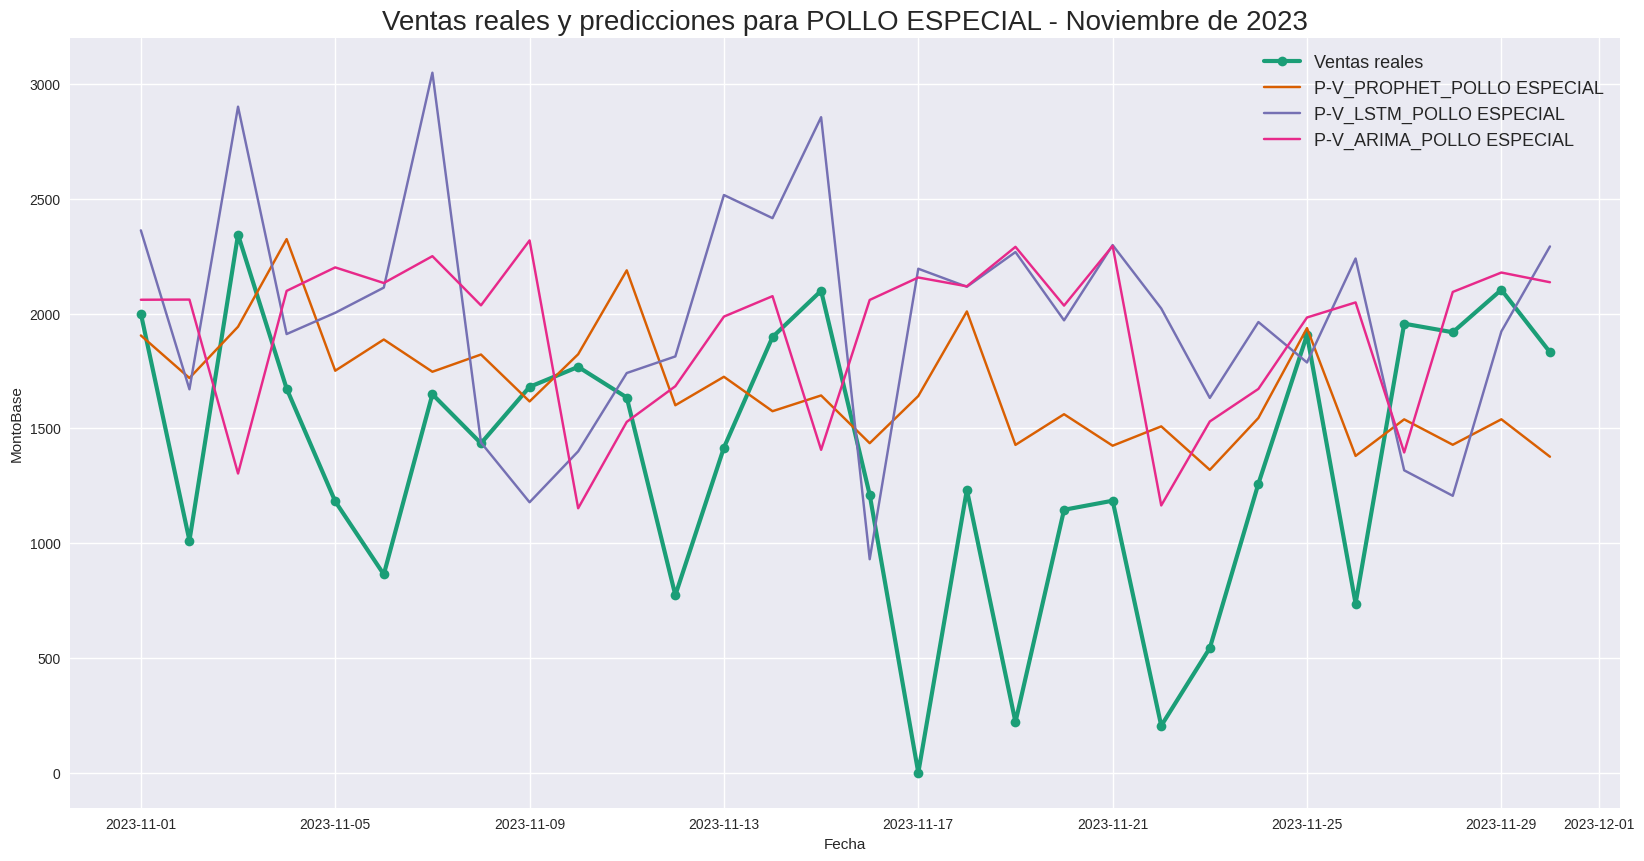

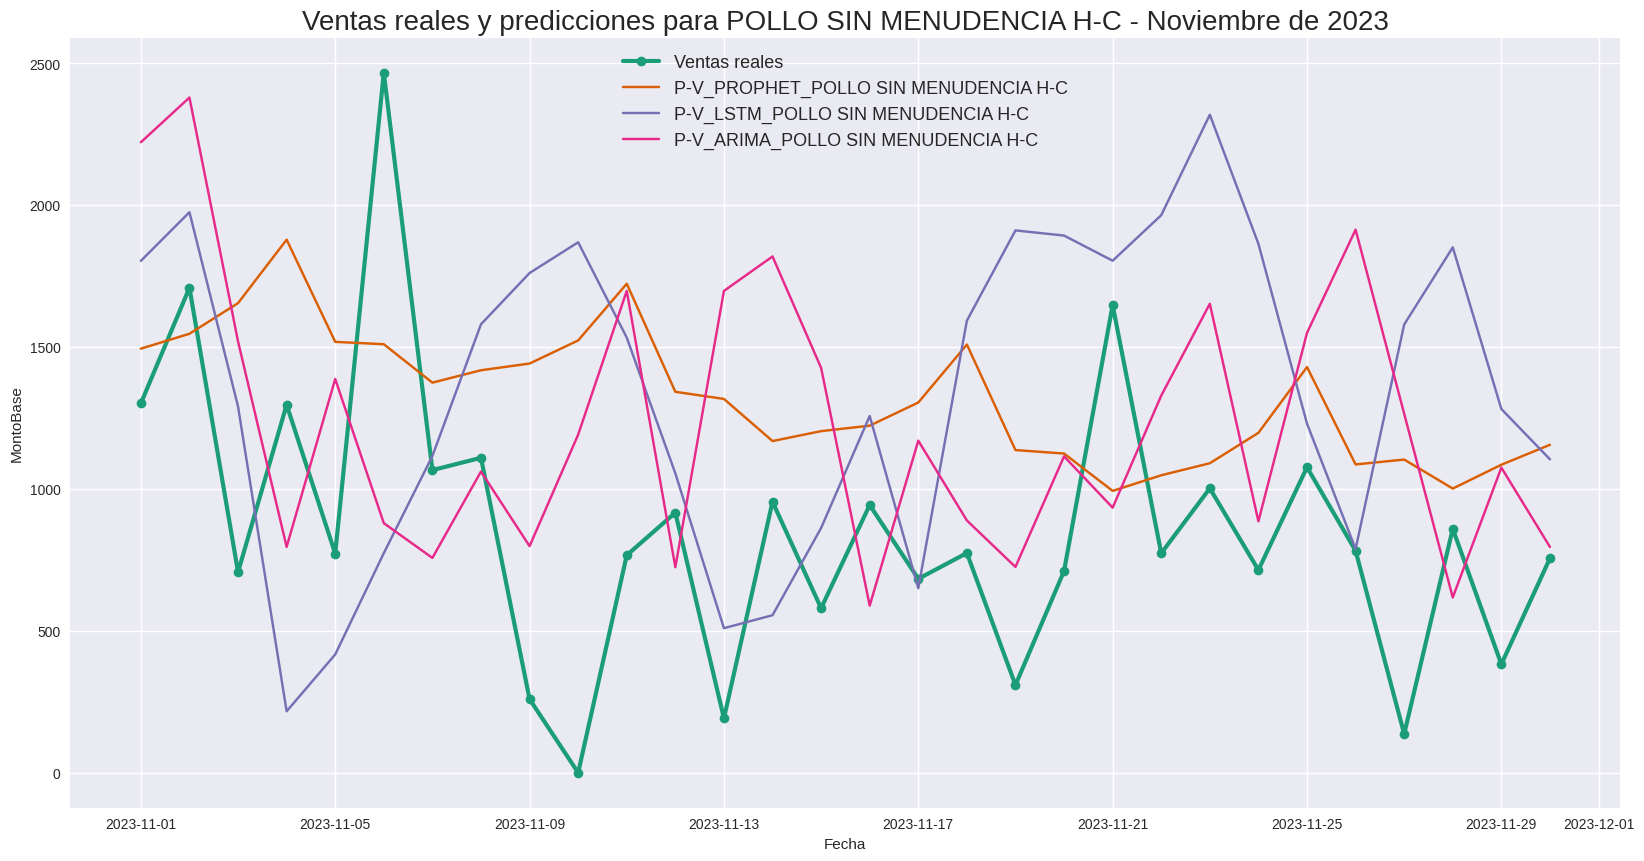

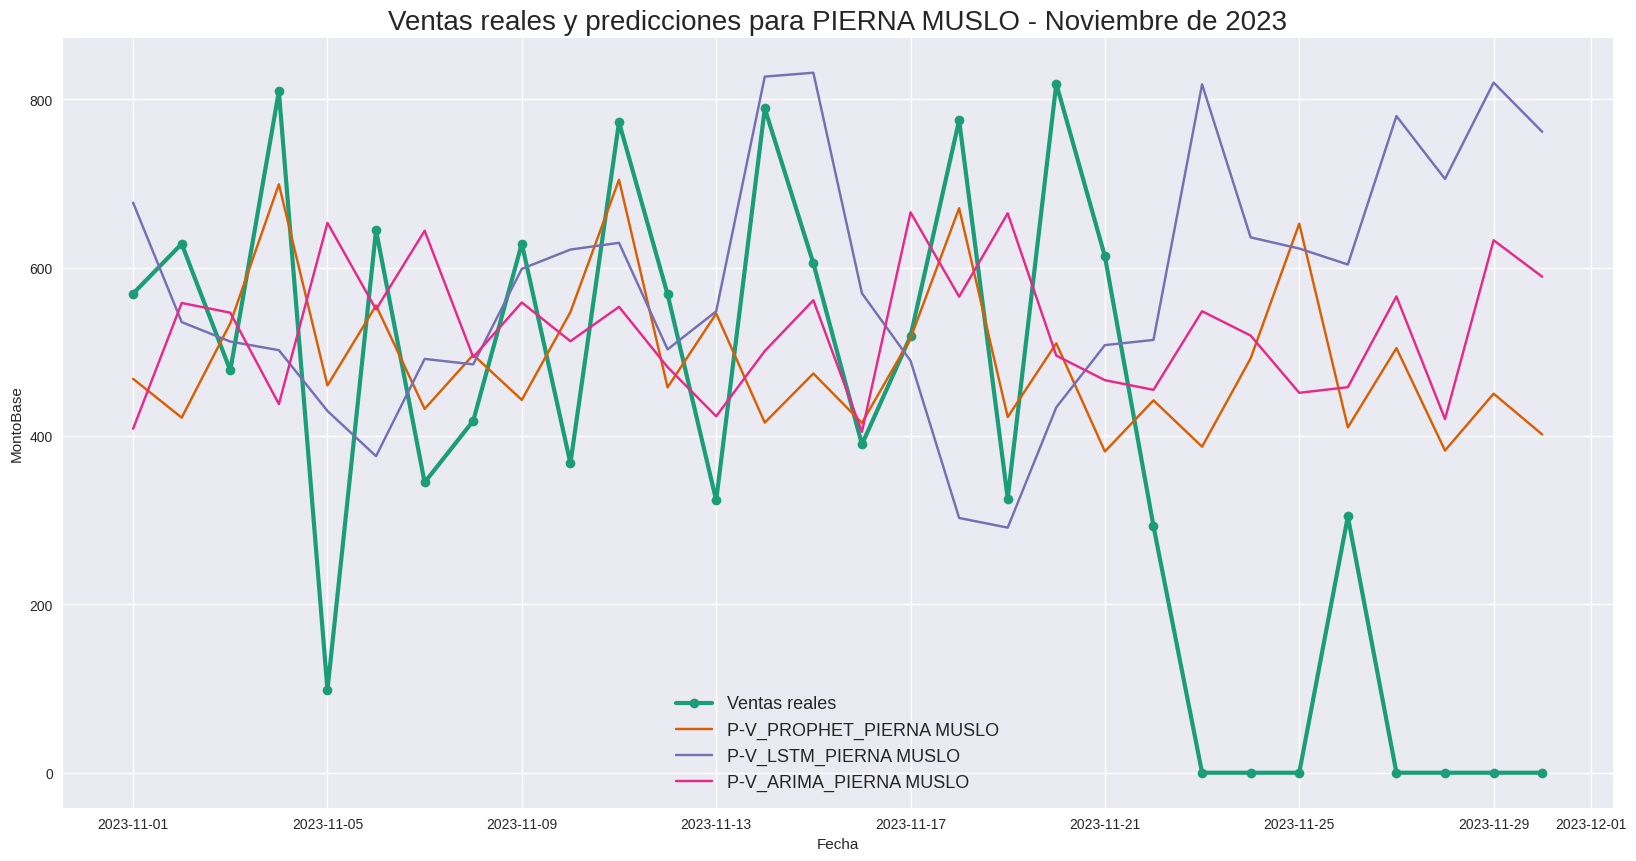

In [66]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales', marker='o', linewidth=3)

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=13)
    plt.show()

In [67]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO ESPECIAL
Modelo: PROPHET
Evaluation metric results:  
MSE is : 426792.14882945165
MAE is : 533.0151344468478
R2 is : -0.1750863323293388 %
------------------------------
MRSE is : 653.2933099530804
MAPE is : 76.34780305799396 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 962450.8400167909
MAE is : 808.5555872233073
R2 is : -1.649914790476993 %
------------------------------
MRSE is : 981.045788950134
MAPE is : 117.26613944209039 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 830239.4728663177
MAE is : 753.4478384922022
R2 is : -1.2858973854164808 %
------------------------------
MRSE is : 911.174776245654
MAPE is : 101.47513585920495

In [68]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df)

                 NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
FechaMovimiento                                                          
2023-11-01       POLLO ESPECIAL  1999.7321                   1904.6724   
2023-11-02       POLLO ESPECIAL  1011.2892                   1719.1750   
2023-11-03       POLLO ESPECIAL  2343.7883                   1942.6333   
2023-11-04       POLLO ESPECIAL  1673.2089                   2324.3057   
2023-11-05       POLLO ESPECIAL  1181.9289                   1750.9780   
2023-11-06       POLLO ESPECIAL   863.7984                   1887.0078   
2023-11-07       POLLO ESPECIAL  1648.4580                   1746.5221   
2023-11-08       POLLO ESPECIAL  1434.6711                   1821.5955   
2023-11-09       POLLO ESPECIAL  1680.6493                   1617.1638   
2023-11-10       POLLO ESPECIAL  1767.7892                   1822.8342   
2023-11-11       POLLO ESPECIAL  1634.3693                   2188.2710   
2023-11-12       POLLO ESPECIAL   773.